Import in all relevant libraries like BeautifulSoup, Pandas, Matplotlib, etc.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install bs4 
from bs4 import BeautifulSoup
!pip install lxml
import requests
from datetime import datetime
import seaborn as sb
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from numpy import mean
from numpy import std
import statsmodels.api as sm

# compare the number of repeats for repeated k-fold cross-validation
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot

# evaluate a logistic and linear regression models 
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score, precision_score, recall_score)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


I need to collect relevant baseball statistics from seasons 2000-2018. One of the best sites to collect baseball statistics is baseball-reference so the code below is written to "webscrape" relevant baseball data from baseball-reference website.

In [2]:
# Web Scraping
# use requests to open and grab the desired html link
html = requests.get('https://www.baseball-reference.com/leagues/MLB/2018-schedule.shtml').text
# employ BeautifulSoup with an appropriate parser to extract
soup = BeautifulSoup(html, 'lxml')
# find all of the games
gameday = soup.find('p', class_='game')
game = soup.find('h3').text

# function that accepts the date from the website and returns
# it in the correct datetime format
def correctDateTime(date):
  d = date.split(' ', 1)[1:]
  substr1 = d[0].split()[0]
  substr2 = d[0].split()[1]
  # remove the comma
  substr2 = substr2.replace(',', '')
  # create appropriate date string to pass to datetime
  gameday = substr2 + " " + substr1 + ", " + d[0].split()[-1]
  # convert gameday to a datetime called date
  day = datetime.strptime(gameday, "%d %B, %Y").date()
  return day

In [3]:
# first let us create a list to hold the names of all 30 MLB teams
columns = []
# first loop through the schedule to find all MLB teams
schedule = soup.find('div', class_='section_content')
gamedays = schedule.find_all('div')
# iterate through gamedays 
for gameday in gamedays:
  # create a sup-soup of all the games
  games = gameday.find_all('p', class_='game')
  # loop through each game
  for game in games:
    awayTeam = game.find('a').text
    homeTeam = game.find('strong').text
    # fix format of homeTeam
    homeTeam = homeTeam.partition('\n')[0]
    # if the first space is blank, delete it
    if homeTeam[0] == ' ':
      homeTeam = homeTeam[1:]
    # add the home team to the list of teams if it had not
    # already been added to the list
    if awayTeam not in columns:
      columns.append(awayTeam)
    if homeTeam not in columns:
      columns.append(homeTeam)

# now let us loop through schedule to find all of the gamedays and
# we shall store them in gamedates
gamedates = []
for gameday in gamedays: 
  date = correctDateTime(gameday.find('h3').text)
  if date not in gamedates:
    gamedates.append(date)

In [4]:
# create dataframe with all 30 MLB teams in the columns and game dates as row indices
gameResults = pd.DataFrame(columns=columns, index=gamedates)

# iterate through gamedays 
for gameday in gamedays:
  date = correctDateTime(gameday.find('h3').text)
  # create a sup-soup of all the games
  games = gameday.find_all('p', class_='game')
  # loop through each game
  for game in games:
    # results of each game
    teams = game.find_all('a')
    awayTeam = teams[0].text
    homeTeam = teams[1].text
    awayRuns = game.text.splitlines()[2]
    homeRuns = game.text.splitlines()[5]
    # remove parentheses and blank spaces
    for i in awayRuns:
      awayRuns = awayRuns.replace('(', '')
      awayRuns = awayRuns.replace(' ', '')
    awayRuns = awayRuns[:-1]
    for i in homeRuns:
      homeRuns = homeRuns.replace('(', '')
      homeRuns = homeRuns.replace(' ', '')
    homeRuns = homeRuns[:-1]

    # make runs ints
    awayRuns = int(awayRuns)
    homeRuns = int(homeRuns)

    # if away team wins
    if awayRuns > homeRuns:
      # create list of info for the winner
      winnerList = [awayRuns, homeRuns]
      # add a +1 label since the game is one
      winnerList.append(1)
      # assign the results to the main dataframe
      gameResults.loc[date][awayTeam] = winnerList
    
      # create list info for loser
      loserList = [homeRuns, awayRuns]
      # add a 0 label reflecting a loss
      loserList.append(0)
      # assign the results to the main dataframe
      gameResults.loc[date][homeTeam] = loserList

    # if home team wins
    elif homeRuns > awayRuns:
      # create list of info for the winner
      winnerList = [homeRuns, awayRuns]
      # add a +1 label since the game is one
      winnerList.append(1)
      # assign the results to the main dataframe
      gameResults.loc[date][homeTeam] = winnerList
    
      # create list info for loser
      loserList = [awayRuns, homeRuns]
      # add a 0 label reflecting a loss
      loserList.append(0)
      # assign the results to the main dataframe
      gameResults.loc[date][awayTeam] = loserList

    gameResults.loc[date][homeTeam] = {'runs_for': gameResults.loc[date, homeTeam][0], 'runs_against': gameResults.loc[date, homeTeam][1], "win/loss": gameResults.loc[date, homeTeam][2]}
    gameResults.loc[date][awayTeam] = {'runs_for': gameResults.loc[date, awayTeam][0], 'runs_against': gameResults.loc[date, awayTeam][1], "win/loss": gameResults.loc[date, awayTeam][2]} 
  
gameResults.head()

,Colorado Rockies,Arizona D'Backs,Philadelphia Phillies,Atlanta Braves,Minnesota Twins,Baltimore Orioles,Chicago White Sox,San Francisco Giants,Chicago Cubs,St. Louis Cardinals,New York Mets,Los Angeles Angels,Oakland Athletics,Milwaukee Brewers,Cleveland Indians,Seattle Mariners,Boston Red Sox,Tampa Bay Rays,Houston Astros,New York Yankees,Washington Nationals,Pittsburgh Pirates,Miami Marlins,Texas Rangers,Los Angeles Dodgers,Toronto Blue Jays,Cincinnati Reds,Kansas City Royals,Detroit Tigers,San Diego Padres
2018-03-29,"{'runs_for': 2, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 8, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 8, 'runs_against': 5, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 3, 'win/loss': 0}","{'runs_for': 3, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 14, 'runs_against': 7, 'win/loss'...","{'runs_for': 1, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 8, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 9, 'win/loss': 0}","{'runs_for': 9, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 6, 'runs_against': 5, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}","{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 6, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 6, 'runs_against': 1, 'win/loss': 1}",NaN,NaN,"{'runs_for': 4, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 1, 'runs_against': 4, 'win/loss': 0}","{'runs_for': 0, 'runs_against': 1, 'win/loss': 0}","{'runs_for': 1, 'runs_against': 6, 'win/loss': 0}",NaN,"{'runs_for': 7, 'runs_against': 14, 'win/loss'...",NaN,"{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}"
2018-03-30,"{'runs_for': 8, 'runs_against': 9, 'win/loss': 0}","{'runs_for': 9, 'runs_against': 8, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 5, 'win/loss': 0}",NaN,NaN,NaN,"{'runs_for': 1, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}",NaN,NaN,"{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}","{'runs_for': 8, 'runs_against': 6, 'win/loss': 1}",NaN,NaN,"{'runs_for': 1, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 0, 'runs_against': 1, 'win/loss': 0}","{'runs_for': 1, 'runs_against': 5, 'win/loss': 0}","{'runs_for': 4, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 13, 'runs_against': 10, 'win/loss...","{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 0, 'runs_against': 1, 'win/loss': 0}","{'runs_for': 2, 'runs_against': 4, 'win/loss': 0}","{'runs_for': 0, 'runs_against': 2, 'win/loss': 0}",NaN,"{'runs_for': 10, 'runs_against': 13, 'win/loss...","{'runs_for': 6, 'runs_against': 8, 'win/loss': 0}"
2018-03-31,"{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}","{'runs_for': 2, 'runs_against': 15, 'win/loss'...","{'runs_for': 15, 'runs_against': 2, 'win/loss'...","{'runs_for': 6, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 4, 'runs_against': 3, 'win/loss': 1}","{'runs_for': 0, 'runs_against': 5, 'win/loss': 0}","{'runs_for': 10, 'runs_against': 6, 'win/loss'...","{'runs_for': 2, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 6, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 8, 'runs_against': 3, 'win/loss': 1}","{'runs_for': 3, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 7, 'runs_against': 3, 'win/loss': 1}","{'runs_for': 6, 'runs_against': 5, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 3, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 2, 'runs_

In [5]:
# make null list
nullList = gameResults.isnull()
# iterate through gamedays 
for i in range(len(gameResults)):
  for j in range(len(gameResults.columns)):
    # ensure that the game is not an off-day (null)
    if nullList.iloc[i][j] == False:
      gameResults.iloc[i][j]['run_differential'] = gameResults.iloc[i][j]['runs_for'] - gameResults.iloc[i][j]['runs_against']
      
for i in range(15, len(gameResults)):
  for j in range(len(gameResults.columns)):
    # make sure game is not an off-day (null)
    if nullList.iloc[i][j] == False:
      # make sure previous game was not an off-day (null)
      # find the most-recent non-off-day
      sum = 0
      # g will be a dummy variable that tracks
      # how far back we go
      g = 0
      for p in range(1,10):
        # make sure the value is non-null
        if nullList.iloc[i-p][j] == False:
          sum += gameResults.iloc[i-p][j]['runs_for']
          # increment g by 1 indicating that we have "found"
          # a previos game
          g +=1
        # stop when g gets to 5 because we only want the last 5 games
        if g > 4:
          break
      # avg = sum/n
      gameResults.iloc[i][j]["5-day_avg_runs"] = sum/5

print('Game Date: ' + str(gameResults.index[-1]))
print('Los Angeles Dodgers\nScore: ' + str(gameResults.iloc[-1]['Los Angeles Dodgers']['runs_for']) \
+ '-' + str(gameResults.iloc[-1]['Los Angeles Dodgers']['runs_against']) + '\nResult(Win/Loss-1/0): '\
+ str(str(gameResults.iloc[-1]['Los Angeles Dodgers']['win/loss'])))
print('Avg. Runs Scored Over Previous 5 Games: ' + str(gameResults.iloc[-1]['Los Angeles Dodgers']['5-day_avg_runs']))

Game Date: 2018-10-01
Los Angeles Dodgers
Score: 5-2
Result(Win/Loss-1/0): 1
Avg. Runs Scored Over Previous 5 Games: 6.6


In [6]:
# aggregate data into one numpy array on which we can employ correlation
winLossList = []
prevGameDiffList = []

# iterate through games by the same procedure as before
for j in range(len(gameResults.columns)):
  for i in range(15, len(gameResults)):
    if nullList.iloc[i][j] == False:
      # append the lists accordingly
      winLossList.append(gameResults.iloc[i][j]['runs_for'])
      prevGameDiffList.append(gameResults.iloc[i][j]['5-day_avg_runs'])

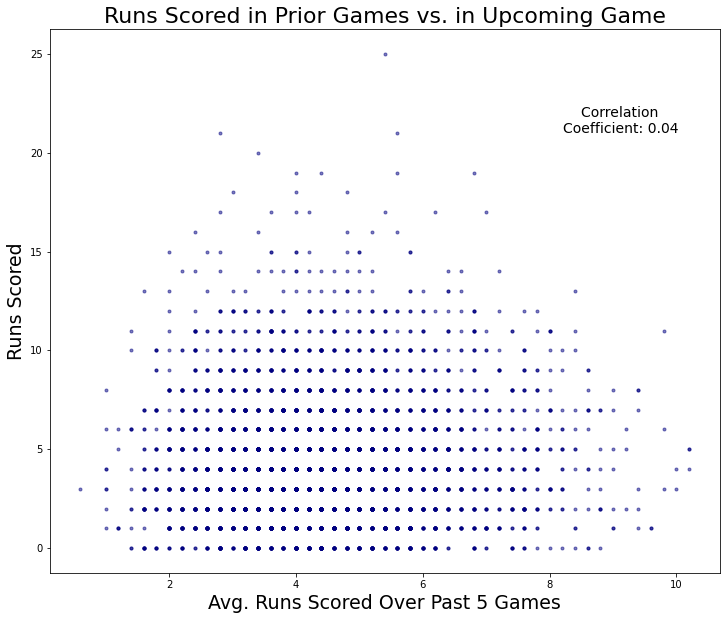

In [7]:
# create releveant numpy arrays
winLossArray = np.array(winLossList)
avgGameDiff = np.array(prevGameDiffList)

plt.scatter(prevGameDiffList, winLossList, marker='.', alpha = .5, color='navy')
plt.gcf().set_size_inches((12,10))
plt.xlabel('Avg. Runs Scored Over Past 5 Games', fontsize = 19)
plt.ylabel('Runs Scored', fontsize = 19)
plt.title('Runs Scored in Prior Games vs. in Upcoming Game', fontsize = 22)
plt.text(8.21, 21, '    Correlation\nCoefficient: ' + str(round(np.corrcoef(winLossArray, avgGameDiff)[1][0], 2)), fontsize=14, color='black')
plt.style.use('ggplot')

plt.show()

What I am beginning to learn is that baseball games are based heavily on how many runs a team can score and how good they are at keeping the other team from scoring. The 2 major baseball skills involved in run creation and run prevention are (1) pitching and (2) batting.

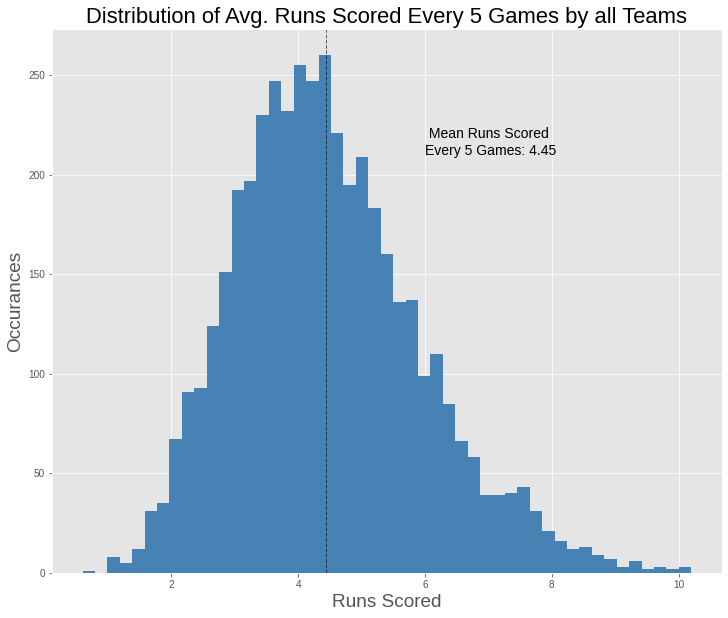

In [8]:
plt.hist(avgGameDiff, bins=49, color='steelblue')
plt.gcf().set_size_inches((12,10))
plt.title('Distribution of Avg. Runs Scored Every 5 Games by all Teams', fontsize = 22)
plt.xlabel('Runs Scored', fontsize=19)
plt.ylabel('Occurances', fontsize=19)
plt.style.use('seaborn')
plt.axvline(avgGameDiff.mean(), color='k', linestyle='dashed', alpha = 0.6, linewidth=1)
plt.text(6, 210, ' Mean Runs Scored\nEvery 5 Games: ' + str(round(avgGameDiff.mean(), 2)), fontsize=14, color='black')
plt.show()

(-0.3, 0.3)

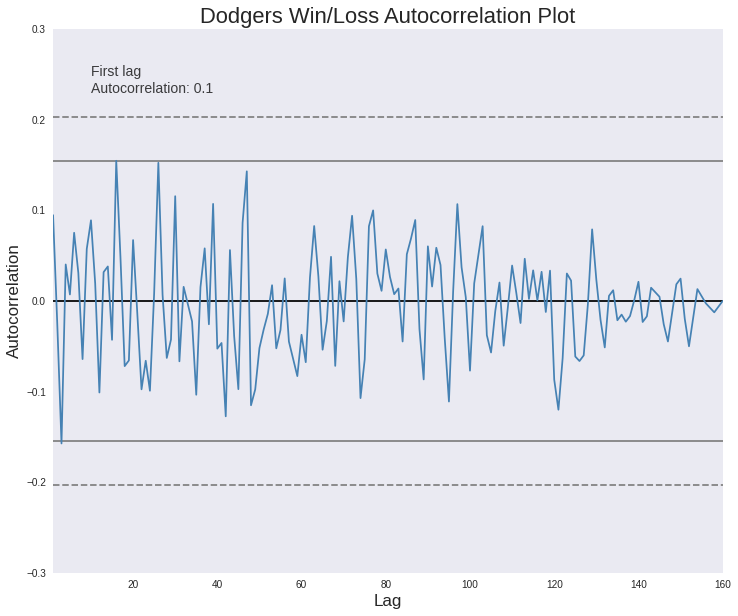

In [9]:
# create lists to hold win/loss info and iterate through the 
# dataframe like before
DodgersWinLoss = []
DodgersWinLossIndex = []
for i in range(len(gameResults)):
  if nullList.iloc[i]['Los Angeles Dodgers'] == False:
    DodgersWinLoss.append(gameResults.iloc[i]['Los Angeles Dodgers']['win/loss'])
    DodgersWinLossIndex.append(gameResults.index[i])

first = np.array(DodgersWinLoss[:-1])
second = np.array(DodgersWinLoss[1:])

autocorrelation_plot(DodgersWinLoss, color='steelblue')
plt.title('Dodgers Win/Loss Autocorrelation Plot', fontsize=22)
plt.gcf().set_size_inches((12,10))
plt.style.use('seaborn')
plt.ylabel('Autocorrelation', fontsize=17)
plt.xlabel('Lag', fontsize=17)
plt.text(10, .23, 'First lag\nAutocorrelation: ' + str(round((np.corrcoef(first, second))[0][1], 2)), fontsize=14, color='black', alpha =.75)
plt.ylim(-.3,.3)

In [10]:
# ARIMA Output
ARIMA_model = ARIMA(DodgersWinLoss, order=(5,0,0))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  160
Model:                     ARMA(5, 0)   Log Likelihood                -111.963
Method:                       css-mle   S.D. of innovations              0.487
Date:                Wed, 18 Aug 2021   AIC                            237.926
Time:                        22:24:52   BIC                            259.452
Sample:                             0   HQIC                           246.667
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5562      0.038     14.640      0.000       0.482       0.631
ar.L1.y        0.1047      0.079      1.321      0.188      -0.051       0.260
ar.L2.y       -0.0206      0.080     -0.258      0.7

[]

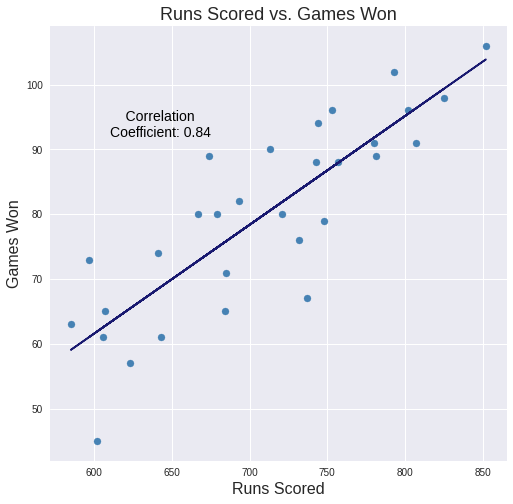

In [11]:
# dump all of the team names into a list
teams = []
for i in range(len(gameResults.columns)):
  teams.append(gameResults.columns[i])

# create dictionaries
wins = {}
runsFor = {}
runsAgainst = {}

# fill in the number of wins, runs for, and runs against
for i in range(len(teams)):
  wins[teams[i]] = 0
for i in range(len(teams)):
  runsFor[teams[i]] = 0
for i in range(len(teams)):
  runsAgainst[teams[i]] = 0

# create a nullList for future checking
# loop through the results and increment each dictionary
nullList = gameResults.isnull()
for i in range(len(gameResults)):
  for j in range(len(teams)):
    if nullList.iloc[i][j] == False: 
      wins[teams[j]] += gameResults.iloc[i][j]['win/loss']
for i in range(len(gameResults)):
  for j in range(len(teams)):
    if nullList.iloc[i][j] == False: 
      runsFor[teams[j]] += gameResults.iloc[i][j]['runs_for']
for i in range(len(gameResults)):
  for j in range(len(teams)):
    if nullList.iloc[i][j] == False: 
      runsAgainst[teams[j]] += gameResults.iloc[i][j]['runs_against']

# create dummy lists so that we can create numpy arrays 
# to perform subsequent operations on
list1 = []
for key, value in wins.items():
  list1.append(value)
winNum = np.array(list1)
list2 = []
for key, value in runsFor.items():
  list2.append(value)
runNum = np.array(list2)
list3 = []
for key, value in runsAgainst.items():
  list3.append(value)
runsAgainstNum = np.array(list3)

# plot both scatter charts and show correlations
fig = plt.figure()
X = runNum[:, np.newaxis]
model = LinearRegression(fit_intercept=True)
model.fit(X, winNum)
plt.subplot(1,2,2)
predictions = model.predict(X)
plt.scatter(X, winNum, color='steelblue')
plt.plot(X, predictions, color='midnightblue')
plt.gcf().set_size_inches((18,8))
plt.xlabel('Runs Scored', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Runs Scored vs. Games Won', fontsize = 18)
plt.text(610, 92, '    Correlation\nCoefficient: ' + str(round(np.corrcoef(winNum, runNum)[1][0], 2)), fontsize=14, color='black')
plt.style.use('seaborn')
plt.plot()

[]

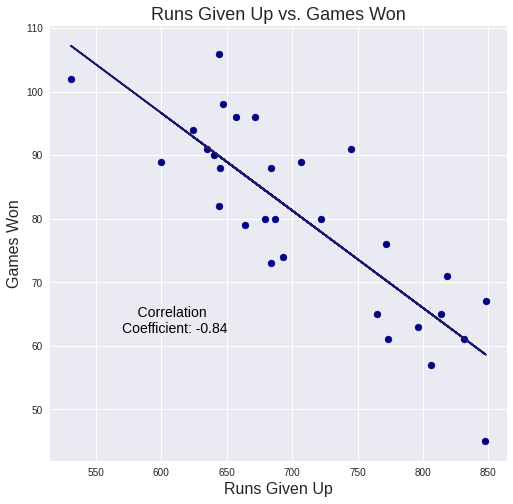

In [12]:
fig = plt.figure()
X2 = runsAgainstNum[:, np.newaxis]
model = LinearRegression(fit_intercept=True)
model.fit(X2, winNum)
plt.subplot(1,2,2)
predictions = model.predict(X2)
plt.scatter(X2, winNum, color='navy')
plt.plot(X2, predictions, color='midnightblue')
#plt.scatter(runsAgainstNum, winNum, alpha = .7, color='navy')
plt.gcf().set_size_inches((18,8))
plt.xlabel('Runs Given Up', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Runs Given Up vs. Games Won', fontsize = 18)
plt.text(570, 62, '    Correlation\nCoefficient: ' + str(round(np.corrcoef(winNum, runsAgainstNum)[1][0], 2)), fontsize=14, color='black')
plt.style.use('seaborn')
plt.plot()

The above graphs show how important runs are in terms of winning baseball games. In the first graph, we see that as runs scored increases the team's games won goes up which is a strong positive correlation. In the second graph, we see that as runs given up goes up that the team's wins goes down which is a strong negative correlation.

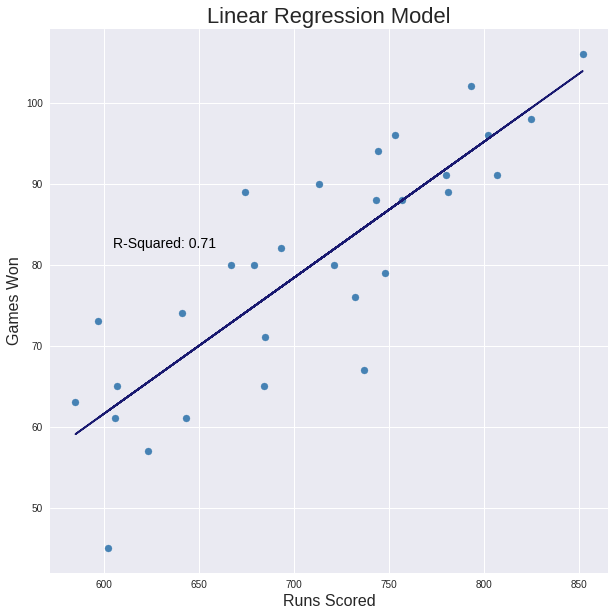

In [13]:
# Linear Regression
X = runNum[:, np.newaxis]
model = LinearRegression(fit_intercept=True)
model.fit(X, winNum)
predictions = model.predict(X)
plt.scatter(X, winNum, color='steelblue')
plt.plot(X, predictions, color='midnightblue')
plt.gcf().set_size_inches((10,10))
plt.text(605, 82, 'R-Squared: ' + str(round((np.corrcoef(winNum, runNum)[1][0])**2, 2)), fontsize=14, color='black')
plt.xlabel('Runs Scored', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Linear Regression Model', fontsize = 22)
plt.style.use('seaborn')

In [14]:
xls = pd.ExcelFile('/content/Baseball_Seasonal_Data.xls')
Pirates = pd.read_excel(xls, 'Pirates')
Reds = pd.read_excel(xls, 'Reds')
WhiteSox = pd.read_excel(xls, 'WhiteSox')
Royals = pd.read_excel(xls, 'Royals')
DBacks = pd.read_excel(xls, 'DBacks')
Dodgers = pd.read_excel(xls, 'Dodgers')
Rockies = pd.read_excel(xls, 'Rockies')
Cardinals = pd.read_excel(xls, 'Cardinals')
Brewers = pd.read_excel(xls, 'Brewers')
Indians = pd.read_excel(xls, 'Indians')
Nationals = pd.read_excel(xls, 'Nationals')
Rangers = pd.read_excel(xls, 'Rangers')
Marlins = pd.read_excel(xls, 'Marlins')
BlueJays = pd.read_excel(xls, 'BlueJays')
Rays = pd.read_excel(xls, 'Rays')
Mets = pd.read_excel(xls, 'Mets')
Tigers = pd.read_excel(xls, 'Tigers')
Cubs = pd.read_excel(xls, 'Cubs')
Astros = pd.read_excel(xls, 'Astros')
RedSox = pd.read_excel(xls, 'RedSox')
Padres = pd.read_excel(xls, 'Padres')
Giants = pd.read_excel(xls, 'Giants')
Twins = pd.read_excel(xls, 'Twins') 
Orioles = pd.read_excel(xls, 'Orioles')
Yankees = pd.read_excel(xls, 'Yankees')
Angels = pd.read_excel(xls, 'Angels')
Athletics = pd.read_excel(xls, 'Athletics')  
Phillies = pd.read_excel(xls, 'Phillies') 
Braves = pd.read_excel(xls, 'Braves')
Mariners = pd.read_excel(xls, 'Mariners')

In [15]:
xls_Rankings = pd.ExcelFile('/content/Baseball_Seasonal_Data_ForRankings.xls')
Pirates_Rankings = pd.read_excel(xls_Rankings, 'Pirates')
Reds_Rankings = pd.read_excel(xls_Rankings, 'Reds')
WhiteSox_Rankings = pd.read_excel(xls_Rankings, 'WhiteSox')
Royals_Rankings = pd.read_excel(xls_Rankings, 'Royals')
DBacks_Rankings = pd.read_excel(xls_Rankings, 'DBacks')
Dodgers_Rankings = pd.read_excel(xls_Rankings, 'Dodgers')
Rockies_Rankings = pd.read_excel(xls_Rankings, 'Rockies')
Cardinals_Rankings = pd.read_excel(xls_Rankings, 'Cardinals')
Brewers_Rankings = pd.read_excel(xls_Rankings, 'Brewers')
Indians_Rankings = pd.read_excel(xls_Rankings, 'Indians')
Nationals_Rankings = pd.read_excel(xls_Rankings, 'Nationals')
Rangers_Rankings = pd.read_excel(xls_Rankings, 'Rangers')
Marlins_Rankings = pd.read_excel(xls_Rankings, 'Marlins')
BlueJays_Rankings = pd.read_excel(xls_Rankings, 'BlueJays')
Rays_Rankings = pd.read_excel(xls_Rankings, 'Rays')
Mets_Rankings = pd.read_excel(xls_Rankings, 'Mets')
Tigers_Rankings = pd.read_excel(xls_Rankings, 'Tigers')
Cubs_Rankings = pd.read_excel(xls_Rankings, 'Cubs')
Astros_Rankings = pd.read_excel(xls_Rankings, 'Astros')
RedSox_Rankings = pd.read_excel(xls_Rankings, 'RedSox')
Padres_Rankings = pd.read_excel(xls_Rankings, 'Padres')
Giants_Rankings = pd.read_excel(xls_Rankings, 'Giants')
Twins_Rankings = pd.read_excel(xls_Rankings, 'Twins') 
Orioles_Rankings = pd.read_excel(xls_Rankings, 'Orioles')
Yankees_Rankings = pd.read_excel(xls_Rankings, 'Yankees')
Angels_Rankings = pd.read_excel(xls_Rankings, 'Angels')
Athletics_Rankings = pd.read_excel(xls_Rankings, 'Athletics')  
Phillies_Rankings = pd.read_excel(xls_Rankings, 'Phillies') 
Braves_Rankings = pd.read_excel(xls_Rankings, 'Braves')
Mariners_Rankings = pd.read_excel(xls_Rankings, 'Mariners')

In [16]:
Cubs_Rankings.Team = 'CHC'
Cubs_Rankings.Rank = 1

Cardinals_Rankings.Team = 'STL'
Cardinals_Rankings.Rank = 2

Dodgers_Rankings.Team = 'LAD'
Dodgers_Rankings.Rank = 3

Rangers_Rankings.Team = 'TEX'
Rangers_Rankings.Rank = 4

BlueJays_Rankings.Team = 'TOR'
BlueJays_Rankings.Rank = 5

Nationals_Rankings.Team = 'WSN'
Nationals_Rankings.Rank = 6

Mets_Rankings.Team = 'NYM'
Mets_Rankings.Rank = 7

Royals_Rankings.Team = 'KCR'
Royals_Rankings.Rank = 8

Pirates_Rankings.Team = 'PIT'
Pirates_Rankings.Rank = 9

Indians_Rankings.Team = 'CLE'
Indians_Rankings.Rank = 10

RedSox_Rankings.Team = 'BOS'
RedSox_Rankings.Rank = 11

Yankees_Rankings.Team = 'NYY'
Yankees_Rankings.Rank = 12

Giants_Rankings.Team = 'SFG'
Giants_Rankings.Rank = 13

Orioles_Rankings.Team = 'BAL'
Orioles_Rankings.Rank = 14

Astros_Rankings.Team = 'HOU'
Astros_Rankings.Rank = 15

Mariners_Rankings.Team = 'SEA'
Mariners_Rankings.Rank = 16

Tigers_Rankings.Team = 'DET'
Tigers_Rankings.Rank = 17

Angels_Rankings.Team = 'LAA'
Angels_Rankings.Rank = 18

WhiteSox_Rankings.Team = 'CHW'
WhiteSox_Rankings.Rank = 19

Marlins_Rankings.Team = 'MIA'
Marlins_Rankings.Rank = 20

DBacks_Rankings.Team = 'ARI'
DBacks_Rankings.Rank = 21

Rays_Rankings.Team = 'TBR'
Rays_Rankings.Rank = 22

Rockies_Rankings.Team = 'COL'
Rockies_Rankings.Rank = 23

Twins_Rankings.Team = 'MIN'
Twins_Rankings.Rank = 24

Padres_Rankings.Team = 'SDP'
Padres_Rankings.Rank = 25

Brewers_Rankings.Team = 'MIL'
Brewers_Rankings.Rank = 26

Athletics_Rankings.Team = 'OAK'
Athletics_Rankings.Rank = 27

Braves_Rankings.Team = 'ATL'
Braves_Rankings.Rank = 28

Phillies_Rankings.Team = 'PHI'
Phillies_Rankings.Rank = 29

Reds_Rankings.Team = 'CIN'
Reds_Rankings.Rank = 30

In [17]:
Angels_Home = pd.DataFrame(Angels, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Astros_Home = pd.DataFrame(Astros, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Athletics_Home = pd.DataFrame(Athletics, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
BlueJays_Home = pd.DataFrame(BlueJays, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Braves_Home = pd.DataFrame(Braves, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Brewers_Home = pd.DataFrame(Brewers, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Cardinals_Home = pd.DataFrame(Cardinals, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Cubs_Home = pd.DataFrame(Cubs, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
DBacks_Home = pd.DataFrame(DBacks, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Dodgers_Home = pd.DataFrame(Dodgers, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Giants_Home = pd.DataFrame(Giants, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Indians_Home = pd.DataFrame(Indians, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Mariners_Home = pd.DataFrame(Mariners, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Marlins_Home = pd.DataFrame(Marlins, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Mets_Home = pd.DataFrame(Mets, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Nationals_Home = pd.DataFrame(Nationals, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Orioles_Home = pd.DataFrame(Orioles, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Padres_Home = pd.DataFrame(Padres, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Phillies_Home = pd.DataFrame(Phillies, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Pirates_Home = pd.DataFrame(Pirates, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Rangers_Home = pd.DataFrame(Rangers, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Rays_Home = pd.DataFrame(Rays, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
RedSox_Home = pd.DataFrame(RedSox, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Reds_Home = pd.DataFrame(Reds, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Rockies_Home = pd.DataFrame(Rockies, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Royals_Home = pd.DataFrame(Royals, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Tigers_Home = pd.DataFrame(Tigers, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Twins_Home = pd.DataFrame(Twins, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
WhiteSox_Home = pd.DataFrame(WhiteSox, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])
Yankees_Home = pd.DataFrame(Yankees, columns = ['Result', 'HomeTeam', 'Runs', 'RA'])

In [18]:
Angels_HomeRank = pd.DataFrame(Angels_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Astros_HomeRank = pd.DataFrame(Astros_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Athletics_HomeRank = pd.DataFrame(Athletics_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
BlueJays_HomeRank = pd.DataFrame(BlueJays_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Braves_HomeRank = pd.DataFrame(Braves_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Brewers_HomeRank = pd.DataFrame(Brewers_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Cardinals_HomeRank = pd.DataFrame(Cardinals_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Cubs_HomeRank = pd.DataFrame(Cubs_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
DBacks_HomeRank = pd.DataFrame(DBacks_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Dodgers_HomeRank = pd.DataFrame(Dodgers_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Giants_HomeRank = pd.DataFrame(Giants_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Indians_HomeRank = pd.DataFrame(Indians_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Mariners_HomeRank = pd.DataFrame(Mariners_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Marlins_HomeRank = pd.DataFrame(Marlins_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Mets_HomeRank = pd.DataFrame(Mets_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Nationals_HomeRank = pd.DataFrame(Nationals_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Orioles_HomeRank = pd.DataFrame(Orioles_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Padres_HomeRank = pd.DataFrame(Padres_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Phillies_HomeRank = pd.DataFrame(Phillies_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Pirates_HomeRank = pd.DataFrame(Pirates_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Rangers_HomeRank = pd.DataFrame(Rangers_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Rays_HomeRank = pd.DataFrame(Rays_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
RedSox_HomeRank = pd.DataFrame(RedSox_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Reds_HomeRank = pd.DataFrame(Reds_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Rockies_HomeRank = pd.DataFrame(Rockies_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Royals_HomeRank = pd.DataFrame(Royals_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Tigers_HomeRank = pd.DataFrame(Tigers_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Twins_HomeRank = pd.DataFrame(Twins_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
WhiteSox_HomeRank = pd.DataFrame(WhiteSox_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])
Yankees_HomeRank = pd.DataFrame(Yankees_Rankings, columns = ['Result', 'HomeTeam', 'Runs', 'RA', 'Rank', 'Team'])

In [19]:
Reds_filtered = Reds_Home[Reds_Home['HomeTeam'] == 1]
Angels_filtered = Angels_Home[Angels_Home['HomeTeam'] == 1]
Astros_filtered = Astros_Home[Astros_Home['HomeTeam'] == 1]
Athletics_filtered = Athletics_Home[Athletics_Home['HomeTeam'] == 1]
BlueJays_filtered = BlueJays_Home[BlueJays_Home['HomeTeam'] == 1]
Braves_filtered = Braves_Home[Braves_Home['HomeTeam'] == 1]
Brewers_filtered = Brewers_Home[Brewers_Home['HomeTeam'] == 1]
Cardinals_filtered = Cardinals_Home[Cardinals_Home['HomeTeam'] == 1]
Cubs_filtered = Cubs_Home[Cubs_Home['HomeTeam'] == 1]
DBacks_filtered = DBacks_Home[DBacks_Home['HomeTeam'] == 1]
Dodgers_filtered = Dodgers_Home[Dodgers_Home['HomeTeam'] == 1]
Giants_filtered = Giants_Home[Giants_Home['HomeTeam'] == 1]
Indians_filtered= Indians_Home[Indians_Home['HomeTeam'] == 1]
Mariners_filtered = Mariners_Home[Mariners_Home['HomeTeam'] == 1]
Marlins_filtered = Marlins_Home[Marlins_Home['HomeTeam'] == 1]
Mets_filtered = Mets_Home[Mets_Home['HomeTeam'] == 1]
Nationals_filtered = Nationals_Home[Nationals_Home['HomeTeam'] == 1]
Orioles_filtered = Orioles_Home[Orioles_Home['HomeTeam'] == 1]
Padres_filtered = Padres_Home[Padres_Home['HomeTeam'] == 1]
Phillies_filtered = Phillies_Home[Phillies_Home['HomeTeam'] == 1]
Pirates_filtered = Pirates_Home[Pirates_Home['HomeTeam'] == 1]
Rangers_filtered = Rangers_Home[Rangers_Home['HomeTeam'] == 1]
Rays_filtered = Rays_Home[Rays_Home['HomeTeam'] == 1]
RedSox_filtered = RedSox_Home[RedSox_Home['HomeTeam'] == 1]
Reds_filtered = Reds_Home[Reds_Home['HomeTeam'] == 1]
Rockies_filtered = Rockies_Home[Rockies_Home['HomeTeam'] == 1]
Royals_filtered = Royals_Home[Royals_Home['HomeTeam'] == 1]
Tigers_filtered = Tigers_Home[Tigers_Home['HomeTeam'] == 1]
Twins_filtered = Twins_Home[Twins_Home['HomeTeam'] == 1]
WhiteSox_filtered = WhiteSox_Home[WhiteSox_Home['HomeTeam'] == 1]
Yankees_filtered = Yankees_Home[Yankees_Home['HomeTeam'] == 1]

In [20]:
Reds_filtered_Ranked = Reds_HomeRank[Reds_HomeRank['HomeTeam'] == 1]
Angels_filtered_Ranked = Angels_HomeRank[Angels_HomeRank['HomeTeam'] == 1]
Astros_filtered_Ranked = Astros_HomeRank[Astros_HomeRank['HomeTeam'] == 1]
Athletics_filtered_Ranked = Athletics_HomeRank[Athletics_HomeRank['HomeTeam'] == 1]
BlueJays_filtered_Ranked = BlueJays_HomeRank[BlueJays_HomeRank['HomeTeam'] == 1]
Braves_filtered_Ranked = Braves_HomeRank[Braves_HomeRank['HomeTeam'] == 1]
Brewers_filtered_Ranked = Brewers_HomeRank[Brewers_HomeRank['HomeTeam'] == 1]
Cardinals_filtered_Ranked = Cardinals_HomeRank[Cardinals_HomeRank['HomeTeam'] == 1]
Cubs_filtered_Ranked = Cubs_HomeRank[Cubs_HomeRank['HomeTeam'] == 1]
DBacks_filtered_Ranked = DBacks_HomeRank[DBacks_HomeRank['HomeTeam'] == 1]
Dodgers_filtered_Ranked = Dodgers_HomeRank[Dodgers_HomeRank['HomeTeam'] == 1]
Giants_filtered_Ranked = Giants_HomeRank[Giants_HomeRank['HomeTeam'] == 1]
Indians_filtered_Ranked = Indians_HomeRank[Indians_HomeRank['HomeTeam'] == 1]
Mariners_filtered_Ranked = Mariners_HomeRank[Mariners_HomeRank['HomeTeam'] == 1]
Marlins_filtered_Ranked = Marlins_HomeRank[Marlins_HomeRank['HomeTeam'] == 1]
Mets_filtered_Ranked = Mets_HomeRank[Mets_HomeRank['HomeTeam'] == 1]
Nationals_filtered_Ranked = Nationals_HomeRank[Nationals_HomeRank['HomeTeam'] == 1]
Orioles_filtered_Ranked = Orioles_HomeRank[Orioles_HomeRank['HomeTeam'] == 1]
Padres_filtered_Ranked = Padres_HomeRank[Padres_HomeRank['HomeTeam'] == 1]
Phillies_filtered_Ranked = Phillies_HomeRank[Phillies_HomeRank['HomeTeam'] == 1]
Pirates_filtered_Ranked = Pirates_HomeRank[Pirates_HomeRank['HomeTeam'] == 1]
Rangers_filtered_Ranked = Rangers_HomeRank[Rangers_HomeRank['HomeTeam'] == 1]
Rays_filtered_Ranked = Rays_HomeRank[Rays_HomeRank['HomeTeam'] == 1]
RedSox_filtered_Ranked = RedSox_HomeRank[RedSox_HomeRank['HomeTeam'] == 1]
Reds_filtered_Ranked = Reds_HomeRank[Reds_HomeRank['HomeTeam'] == 1]
Rockies_filtered_Ranked = Rockies_HomeRank[Rockies_HomeRank['HomeTeam'] == 1]
Royals_filtered_Ranked = Royals_HomeRank[Royals_HomeRank['HomeTeam'] == 1]
Tigers_filtered_Ranked = Tigers_HomeRank[Tigers_HomeRank['HomeTeam'] == 1]
Twins_filtered_Ranked = Twins_HomeRank[Twins_HomeRank['HomeTeam'] == 1]
WhiteSox_filtered_Ranked = WhiteSox_HomeRank[WhiteSox_HomeRank['HomeTeam'] == 1]
Yankees_filtered_Ranked = Yankees_HomeRank[Yankees_HomeRank['HomeTeam'] == 1]

In [21]:
df_Angels = Angels_filtered.copy()
df_Angels['HomeWin'] = df_Angels.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Astros = Astros_filtered.copy()
df_Astros['HomeWin'] = df_Astros.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Athletics = Athletics_filtered.copy()
df_Athletics['HomeWin'] = df_Athletics.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_BlueJays = BlueJays_filtered.copy()
df_BlueJays['HomeWin'] = df_BlueJays.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Braves = Braves_filtered.copy()
df_Braves['HomeWin'] = df_Braves.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Brewers = Brewers_filtered.copy()
df_Brewers['HomeWin'] = df_Brewers.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Cardinals = Cardinals_filtered.copy()
df_Cardinals['HomeWin'] = df_Cardinals.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Cubs = Cubs_filtered.copy()
df_Cubs['HomeWin'] = df_Cubs.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_DBacks = DBacks_filtered.copy()
df_DBacks['HomeWin'] = df_DBacks.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Dodgers = Dodgers_filtered.copy()
df_Dodgers['HomeWin'] = df_Dodgers.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Giants = Giants_filtered.copy()
df_Giants['HomeWin'] = df_Giants.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Indians = Indians_filtered.copy()
df_Indians['HomeWin'] = df_Indians.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Mariners = Mariners_filtered.copy()
df_Mariners['HomeWin'] = df_Mariners.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Marlins = Marlins_filtered.copy()
df_Marlins['HomeWin'] = df_Marlins.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Mets = Mets_filtered.copy()
df_Mets['HomeWin'] = df_Mets.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Nationals = Nationals_filtered.copy()
df_Nationals['HomeWin'] = df_Nationals.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Orioles = Orioles_filtered.copy()
df_Orioles['HomeWin'] = df_Orioles.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Padres = Padres_filtered.copy()
df_Padres['HomeWin'] = df_Padres.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Phillies = Phillies_filtered.copy()
df_Phillies['HomeWin'] = df_Phillies.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Pirates = Pirates_filtered.copy()
df_Pirates['HomeWin'] = df_Pirates.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Rangers = Rangers_filtered.copy()
df_Rangers['HomeWin'] = df_Rangers.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Rays = Rays_filtered.copy()
df_Rays['HomeWin'] = df_Rays.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_RedSox = RedSox_filtered.copy()
df_RedSox['HomeWin'] = df_RedSox.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Reds = Reds_filtered.copy()
df_Reds['HomeWin'] = df_Reds.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Rockies = Rockies_filtered.copy()
df_Rockies['HomeWin'] = df_Rockies.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Royals = Royals_filtered.copy()
df_Royals['HomeWin'] = df_Royals.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Tigers = Tigers_filtered.copy()
df_Tigers['HomeWin'] = df_Tigers.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Twins = Twins_filtered.copy()
df_Twins['HomeWin'] = df_Twins.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_WhiteSox = WhiteSox_filtered.copy()
df_WhiteSox['HomeWin'] = df_WhiteSox.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Yankees = Yankees_filtered.copy()
df_Yankees['HomeWin'] = df_Yankees.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

In [22]:
df_Angels_Ranked = Angels_filtered_Ranked.copy()
df_Angels_Ranked['HomeWin'] = df_Angels_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Astros_Ranked = Astros_filtered_Ranked.copy()
df_Astros_Ranked['HomeWin'] = df_Astros_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Athletics_Ranked = Athletics_filtered_Ranked.copy()
df_Athletics_Ranked['HomeWin'] = df_Athletics_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_BlueJays_Ranked = BlueJays_filtered_Ranked.copy()
df_BlueJays_Ranked['HomeWin'] = df_BlueJays_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Braves_Ranked = Braves_filtered_Ranked.copy()
df_Braves_Ranked['HomeWin'] = df_Braves_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Brewers_Ranked = Brewers_filtered_Ranked.copy()
df_Brewers_Ranked['HomeWin'] = df_Brewers_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Cardinals_Ranked = Cardinals_filtered_Ranked.copy()
df_Cardinals_Ranked['HomeWin'] = df_Cardinals_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Cubs_Ranked = Cubs_filtered_Ranked.copy()
df_Cubs_Ranked['HomeWin'] = df_Cubs_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_DBacks_Ranked = DBacks_filtered_Ranked.copy()
df_DBacks_Ranked['HomeWin'] = df_DBacks_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Dodgers_Ranked = Dodgers_filtered_Ranked.copy()
df_Dodgers_Ranked['HomeWin'] = df_Dodgers_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Giants_Ranked = Giants_filtered_Ranked.copy()
df_Giants_Ranked['HomeWin'] = df_Giants_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Indians_Ranked = Indians_filtered_Ranked.copy()
df_Indians_Ranked['HomeWin'] = df_Indians_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Mariners_Ranked = Mariners_filtered_Ranked.copy()
df_Mariners_Ranked['HomeWin'] = df_Mariners_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Marlins_Ranked = Marlins_filtered_Ranked.copy()
df_Marlins_Ranked['HomeWin'] = df_Marlins_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Mets_Ranked = Mets_filtered_Ranked.copy()
df_Mets_Ranked['HomeWin'] = df_Mets_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Nationals_Ranked = Nationals_filtered_Ranked.copy()
df_Nationals_Ranked['HomeWin'] = df_Nationals_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Orioles_Ranked = Orioles_filtered_Ranked.copy()
df_Orioles_Ranked['HomeWin'] = df_Orioles_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Padres_Ranked = Padres_filtered_Ranked.copy()
df_Padres_Ranked['HomeWin'] = df_Padres_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Phillies_Ranked = Phillies_filtered_Ranked.copy()
df_Phillies_Ranked['HomeWin'] = df_Phillies_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Pirates_Ranked = Pirates_filtered_Ranked.copy()
df_Pirates_Ranked['HomeWin'] = df_Pirates_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Rangers_Ranked = Rangers_filtered_Ranked.copy()
df_Rangers_Ranked['HomeWin'] = df_Rangers_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Rays_Ranked = Rays_filtered_Ranked.copy()
df_Rays_Ranked['HomeWin'] = df_Rays_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_RedSox_Ranked = RedSox_filtered_Ranked.copy()
df_RedSox_Ranked['HomeWin'] = df_RedSox_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Reds_Ranked = Reds_filtered_Ranked.copy()
df_Reds_Ranked['HomeWin'] = df_Reds_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Rockies_Ranked = Rockies_filtered_Ranked.copy()
df_Rockies_Ranked['HomeWin'] = df_Rockies_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Royals_Ranked = Royals_filtered_Ranked.copy()
df_Royals_Ranked['HomeWin'] = df_Royals_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Tigers_Ranked = Tigers_filtered_Ranked.copy()
df_Tigers_Ranked['HomeWin'] = df_Tigers_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Twins_Ranked = Twins_filtered_Ranked.copy()
df_Twins_Ranked['HomeWin'] = df_Twins_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_WhiteSox_Ranked = WhiteSox_filtered_Ranked.copy()
df_WhiteSox_Ranked['HomeWin'] = df_WhiteSox_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

df_Yankees_Ranked = Yankees_filtered_Ranked.copy()
df_Yankees_Ranked['HomeWin'] = df_Yankees_Ranked.loc[:,'Result'].apply(lambda x: 1 if x == 1 else 0)

In [23]:
df_Angels

,Result,HomeTeam,Runs,RA,HomeWin
0,0.0,1.0,2.0,3.0,0
1,0.0,1.0,3.0,5.0,0
2,1.0,1.0,12.0,6.0,1
4,1.0,1.0,7.0,3.0,1
5,1.0,1.0,7.0,5.0,1
...,...,...,...,...,...
3610,0.0,1.0,2.0,3.0,0
3611,1.0,1.0,4.0,3.0,1
3612,0.0,1.0,0.0,4.0,0
3613,0.0,1.0,3.0,6.0,0


In [24]:
df_Angels_Ranked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin
0,0.0,1.0,2.0,3.0,18,LAA,0
1,0.0,1.0,3.0,5.0,18,LAA,0
2,1.0,1.0,12.0,6.0,18,LAA,1
4,1.0,1.0,7.0,3.0,18,LAA,1
5,1.0,1.0,7.0,5.0,18,LAA,1
...,...,...,...,...,...,...,...
3610,0.0,1.0,2.0,3.0,18,LAA,0
3611,1.0,1.0,4.0,3.0,18,LAA,1
3612,0.0,1.0,0.0,4.0,18,LAA,0
3613,0.0,1.0,3.0,6.0,18,LAA,0


In [25]:
df_MLB_HomeTeamsRanked = df_Angels_Ranked.append(df_Astros_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Athletics_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_BlueJays_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Braves_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Brewers_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Cardinals_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Cubs_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_DBacks_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Dodgers_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Giants_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Indians_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Mariners_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Marlins_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Mets_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Nationals_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Orioles_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Padres_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Phillies_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Pirates_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Rangers_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Rays_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Reds_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_RedSox_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Rockies_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Royals_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Tigers_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Twins_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_WhiteSox_Ranked)
df_MLB_HomeTeamsRanked = df_MLB_HomeTeamsRanked.append(df_Yankees_Ranked)

In [26]:
df_MLB_HomeTeams = df_Angels.append(df_Astros)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Athletics)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_BlueJays)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Braves)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Brewers)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Cardinals)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Cubs)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_DBacks)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Dodgers)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Giants)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Indians)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Mariners)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Marlins)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Mets)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Nationals)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Orioles)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Padres)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Phillies)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Pirates)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Rangers)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Rays)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Reds)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_RedSox)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Rockies)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Royals)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Tigers)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Twins)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_WhiteSox)
df_MLB_HomeTeams = df_MLB_HomeTeams.append(df_Yankees)

In [27]:
df_MLB_HomeTeams

,Result,HomeTeam,Runs,RA,HomeWin
0,0.0,1.0,2.0,3.0,0
1,0.0,1.0,3.0,5.0,0
2,1.0,1.0,12.0,6.0,1
4,1.0,1.0,7.0,3.0,1
5,1.0,1.0,7.0,5.0,1
...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,0
3604,1.0,1.0,9.0,1.0,1
3605,0.0,1.0,3.0,4.0,0
3606,1.0,1.0,7.0,2.0,1


In [28]:
df_MLB_HomeTeamsRanked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin
0,0.0,1.0,2.0,3.0,18,LAA,0
1,0.0,1.0,3.0,5.0,18,LAA,0
2,1.0,1.0,12.0,6.0,18,LAA,1
4,1.0,1.0,7.0,3.0,18,LAA,1
5,1.0,1.0,7.0,5.0,18,LAA,1
...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,12,NYY,0
3604,1.0,1.0,9.0,1.0,12,NYY,1
3605,0.0,1.0,3.0,4.0,12,NYY,0
3606,1.0,1.0,7.0,2.0,12,NYY,1


Machine learning is a smart alternative to analyzing vast amounts of data. Based on the tasks performed and the nature of the output, you can classify machine learning models into three types:
Regression: where the output variable to be predicted is a continuous variable
Classification: where the output variable to be predicted is a categorical variable
Clustering: where there is no pre-defined notion of a label allocated to the groups/clusters formed.
A large number of important problem areas within the realm of classification — an important area of supervised machine learning. And despite the term ‘Regression’ in Logistic Regression — it is, in fact, one of the most basic classification algorithms. Unlike linear regression which outputs continuous number values, logistic regression uses the logistic sigmoid function to transform its output to return a probability value which can then be mapped to two or more discrete classes.
Types of Logistic Regression:
Binary (true/false, yes/no)
Multi-class (sheep, cats, dogs)
Ordinal (Job satisfaction level — dissatisfied, satisfied, highly satisfied)

Citation: https://towardsdatascience.com/multivariate-logistic-regression-in-python-7c6255a286ec


In [29]:
n_games = df_Reds["HomeWin"].count()
n_games

1604

In [30]:
n_homewins = df_Reds["HomeWin"].sum()
n_homewins

806

In [31]:
Team_Names = pd.read_csv('/content/Team_Names.csv')

In [32]:
#I need this to pull in the MLB team names
Team_Names

,Team
0,Angels
1,Astros
2,Athletics
3,BlueJays
4,Braves
5,Brewers
6,Cardinals
7,Cubs
8,Dbacks
9,Dodgers


In [33]:
# create an Empty DataFrame
# object With column names only
df_WinPer_Model = pd.DataFrame(columns = ['Win_Percent'], index=[Team_Names.Team[0:30]])
df_WinPer_Model

,Win_Percent
Team,
Angels,NaN
Astros,NaN
Athletics,NaN
BlueJays,NaN
Braves,NaN
Brewers,NaN
Cardinals,NaN
Cubs,NaN
Dbacks,NaN


In [34]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Angels_games = df_Angels["HomeWin"].count()
Angels_homewins = df_Angels["HomeWin"].sum()
win_percentage = Angels_homewins / Angels_games

print ("Angels Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Angels Home Win Percentage: 56.3%


In [35]:
df_WinPer_Model.loc['Angels'] = [win_percentage]

In [36]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Astros_games = df_Astros["HomeWin"].count()
Astros_homewins = df_Astros["HomeWin"].sum()
win_percentage = Astros_homewins / Astros_games

print ("Astros Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Astros Home Win Percentage: 54.1%


In [37]:
df_WinPer_Model.loc['Astros'] = [win_percentage]

In [38]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Athletics_games = df_Athletics["HomeWin"].count()
Athletics_homewins = df_Athletics["HomeWin"].sum()
win_percentage = Athletics_homewins / Athletics_games

print ("Athletics Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Athletics Home Win Percentage: 57.7%


In [39]:
df_WinPer_Model.loc['Athletics'] = [win_percentage]

In [40]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
BlueJays_games = df_BlueJays["HomeWin"].count()
BlueJays_homewins = df_BlueJays["HomeWin"].sum()
win_percentage = BlueJays_homewins / BlueJays_games

print ("BlueJays Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

BlueJays Home Win Percentage: 53.8%


In [41]:
df_WinPer_Model.loc['BlueJays'] = [win_percentage]

In [42]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Braves_games = df_Braves["HomeWin"].count()
Braves_homewins = df_Braves["HomeWin"].sum()
win_percentage = Braves_homewins / Braves_games

print ("Braves Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Braves Home Win Percentage: 56.9%


In [43]:
df_WinPer_Model.loc['Braves'] = [win_percentage]

In [44]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Brewers_games = df_Brewers["HomeWin"].count()
Brewers_homewins = df_Brewers["HomeWin"].sum()
win_percentage = Brewers_homewins / Brewers_games

print ("Brewers Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Brewers Home Win Percentage: 52.7%


In [45]:
df_WinPer_Model.loc['Brewers'] = [win_percentage]

In [46]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Cardinals_games = df_Cardinals["HomeWin"].count()
Cardinals_homewins = df_Cardinals["HomeWin"].sum()
win_percentage = Cardinals_homewins / Cardinals_games

print ("Cardinals Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Cardinals Home Win Percentage: 59.9%


In [47]:
df_WinPer_Model.loc['Cardinals'] = [win_percentage]

In [48]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Cubs_games = df_Cubs["HomeWin"].count()
Cubs_homewins = df_Cubs["HomeWin"].sum()
win_percentage = Cubs_homewins / Cubs_games

print ("Cubs Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Cubs Home Win Percentage: 53.8%


In [49]:
df_WinPer_Model.loc['Cubs'] = [win_percentage]

In [50]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
DBacks_games = df_DBacks["HomeWin"].count()
DBacks_homewins = df_DBacks["HomeWin"].sum()
win_percentage = DBacks_homewins / DBacks_games

print ("Diamondbacks Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Diamondbacks Home Win Percentage: 52.5%


In [51]:
df_WinPer_Model.loc['Diamondbacks'] = [win_percentage]

In [52]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Dodgers_games = df_Dodgers["HomeWin"].count()
Dodgers_homewins = df_Dodgers["HomeWin"].sum()
win_percentage = Dodgers_homewins / Dodgers_games

print ("Dodgers Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Dodgers Home Win Percentage: 58.7%


In [53]:
df_WinPer_Model.loc['Dodgers'] = [win_percentage]

In [54]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Giants_games = df_Giants["HomeWin"].count()
Giants_homewins = df_Giants["HomeWin"].sum()
win_percentage = Giants_homewins / Giants_games

print ("Giants Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Giants Home Win Percentage: 55.5%


In [55]:
df_WinPer_Model.loc['Giants'] = [win_percentage]

In [56]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Indians_games = df_Indians["HomeWin"].count()
Indians_homewins = df_Indians["HomeWin"].sum()
win_percentage = Indians_homewins / Indians_games

print ("Indians Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Indians Home Win Percentage: 55.0%


In [57]:
df_WinPer_Model.loc['Indians'] = [win_percentage]

In [58]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Mariners_games = df_Mariners["HomeWin"].count()
Mariners_homewins = df_Mariners["HomeWin"].sum()
win_percentage = Mariners_homewins / Mariners_games

print ("Mariners Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Mariners Home Win Percentage: 52.0%


In [59]:
df_WinPer_Model.loc['Mariners'] = [win_percentage]

In [60]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Marlins_games = df_Marlins["HomeWin"].count()
Marlins_homewins = df_Marlins["HomeWin"].sum()
win_percentage = Marlins_homewins / Marlins_games

print ("Marlins Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Marlins Home Win Percentage: 50.9%


In [61]:
df_WinPer_Model.loc['Marlins'] = [win_percentage]

In [62]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Mets_games = df_Mets["HomeWin"].count()
Mets_homewins = df_Mets["HomeWin"].sum()
win_percentage = Mets_homewins / Mets_games

print ("Mets Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Mets Home Win Percentage: 52.0%


In [63]:
df_WinPer_Model.loc['Mets'] = [win_percentage]

In [64]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Nationals_games = df_Nationals["HomeWin"].count()
Nationals_homewins = df_Nationals["HomeWin"].sum()
win_percentage = Nationals_homewins / Nationals_games

print ("Nationals Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Nationals Home Win Percentage: 53.1%


In [65]:
df_WinPer_Model.loc['Nationals'] = [win_percentage]

In [66]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Orioles_games = df_Orioles["HomeWin"].count()
Orioles_homewins = df_Orioles["HomeWin"].sum()
win_percentage = Orioles_homewins / Orioles_games

print ("Orioles Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Orioles Home Win Percentage: 48.7%


In [67]:
df_WinPer_Model.loc['Orioles'] = [win_percentage]

In [68]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Padres_games = df_Padres["HomeWin"].count()
Padres_homewins = df_Padres["HomeWin"].sum()
win_percentage = Padres_homewins / Padres_games

print ("Padres Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Padres Home Win Percentage: 50.0%


In [69]:
df_WinPer_Model.loc['Padres'] = [win_percentage]

In [70]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Phillies_games = df_Phillies["HomeWin"].count()
Phillies_homewins = df_Phillies["HomeWin"].sum()
win_percentage = Phillies_homewins / Phillies_games

print ("Phillies Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Phillies Home Win Percentage: 53.7%


In [71]:
df_WinPer_Model.loc['Phillies'] = [win_percentage]

In [72]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Pirates_games = df_Pirates["HomeWin"].count()
Pirates_homewins = df_Pirates["HomeWin"].sum()
win_percentage = Pirates_homewins / Pirates_games

print ("Pirates Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Pirates Home Win Percentage: 50.7%


In [73]:
df_WinPer_Model.loc['Pirates'] = [win_percentage]

In [74]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Rangers_games = df_Rangers["HomeWin"].count()
Rangers_homewins = df_Rangers["HomeWin"].sum()
win_percentage = Rangers_homewins / Rangers_games

print ("Rangers Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Rangers Home Win Percentage: 54.3%


In [75]:
df_WinPer_Model.loc['Rangers'] = [win_percentage]

In [76]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Rays_games = df_Rays["HomeWin"].count()
Rays_homewins = df_Rays["HomeWin"].sum()
win_percentage = Rays_homewins / Rays_games

print ("Rays Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Rays Home Win Percentage: 52.7%


In [77]:
df_WinPer_Model.loc['Rays'] = [win_percentage]

In [78]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Reds_games = df_Reds["HomeWin"].count()
Reds_homewins = df_Reds["HomeWin"].sum()
win_percentage = Reds_homewins / Reds_games

print ("Reds Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Reds Home Win Percentage: 50.2%


In [79]:
df_WinPer_Model.loc['Reds'] = [win_percentage]

In [80]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
RedSox_games = df_RedSox["HomeWin"].count()
RedSox_homewins = df_RedSox["HomeWin"].sum()
win_percentage = RedSox_homewins / RedSox_games

print ("RedSox Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

RedSox Home Win Percentage: 58.5%


In [81]:
df_WinPer_Model.loc['RedSox'] = [win_percentage]

In [82]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Rockies_games = df_Rockies["HomeWin"].count()
Rockies_homewins = df_Rockies["HomeWin"].sum()
win_percentage = Rockies_homewins / Rockies_games

print ("Rockies Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Rockies Home Win Percentage: 54.5%


In [83]:
df_WinPer_Model.loc['Rockies'] = [win_percentage]

In [84]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Royals_games = df_Royals["HomeWin"].count()
Royals_homewins = df_Royals["HomeWin"].sum()
win_percentage = Royals_homewins / Royals_games

print ("Royals Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Royals Home Win Percentage: 47.5%


In [85]:
df_WinPer_Model.loc['Royals'] = [win_percentage]

In [86]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Tigers_games = df_Tigers["HomeWin"].count()
Tigers_homewins = df_Tigers["HomeWin"].sum()
win_percentage = Tigers_homewins / Tigers_games

print ("Tigers Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Tigers Home Win Percentage: 50.6%


In [87]:
df_WinPer_Model.loc['Tigers'] = [win_percentage]

In [88]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Twins_games = df_Twins["HomeWin"].count()
Twins_homewins = df_Twins["HomeWin"].sum()
win_percentage = Twins_homewins / Twins_games

print ("Twins Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Twins Home Win Percentage: 53.9%


In [89]:
df_WinPer_Model.loc['Twins'] = [win_percentage]

In [90]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
WhiteSox_games = df_WhiteSox["HomeWin"].count()
WhiteSox_homewins = df_WhiteSox["HomeWin"].sum()
win_percentage = WhiteSox_homewins / WhiteSox_games

print ("WhiteSox Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

WhiteSox Home Win Percentage: 53.4%


In [91]:
df_WinPer_Model.loc['WhiteSox'] = [win_percentage]

In [92]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Yankees_games = df_Yankees["HomeWin"].count()
Yankees_homewins = df_Yankees["HomeWin"].sum()
win_percentage = Yankees_homewins / Yankees_games

print ("Yankees Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Yankees Home Win Percentage: 62.5%


In [93]:
df_WinPer_Model.loc['Yankees'] = [win_percentage]

In [94]:
#Create the baseline: Home Teams win games more frequently--this is true in most sports!
Totals_games = df_MLB_HomeTeams["HomeWin"].count()
Total_homewins = df_MLB_HomeTeams["HomeWin"].sum()
win_percentage = Total_homewins / Totals_games

print ("MLB Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

MLB Home Win Percentage: 53.9%


In [95]:
df_WinPer_Model_results = pd.read_csv('/content/df_WinPer_Model_results.csv')
df_WinPer_Model_results

,Team,Win_Percent
0,Angels,56.27
1,Astros,54.08
2,Athletics,57.74
3,BlueJays,53.77
4,Braves,56.91
5,Brewers,52.68
6,Cardinals,59.93
7,Cubs,53.82
8,Dbacks,52.47
9,Dodgers,58.73


In [96]:
Win_Per = df_WinPer_Model_results.Win_Percent
Team = df_WinPer_Model_results.Team

#Win_Per = df_WinPer_Model_results.Win_Percent.astype(float)
#Team = df_WinPer_Model_results.Team.astype(float)

In [97]:
min(Win_Per)

47.46

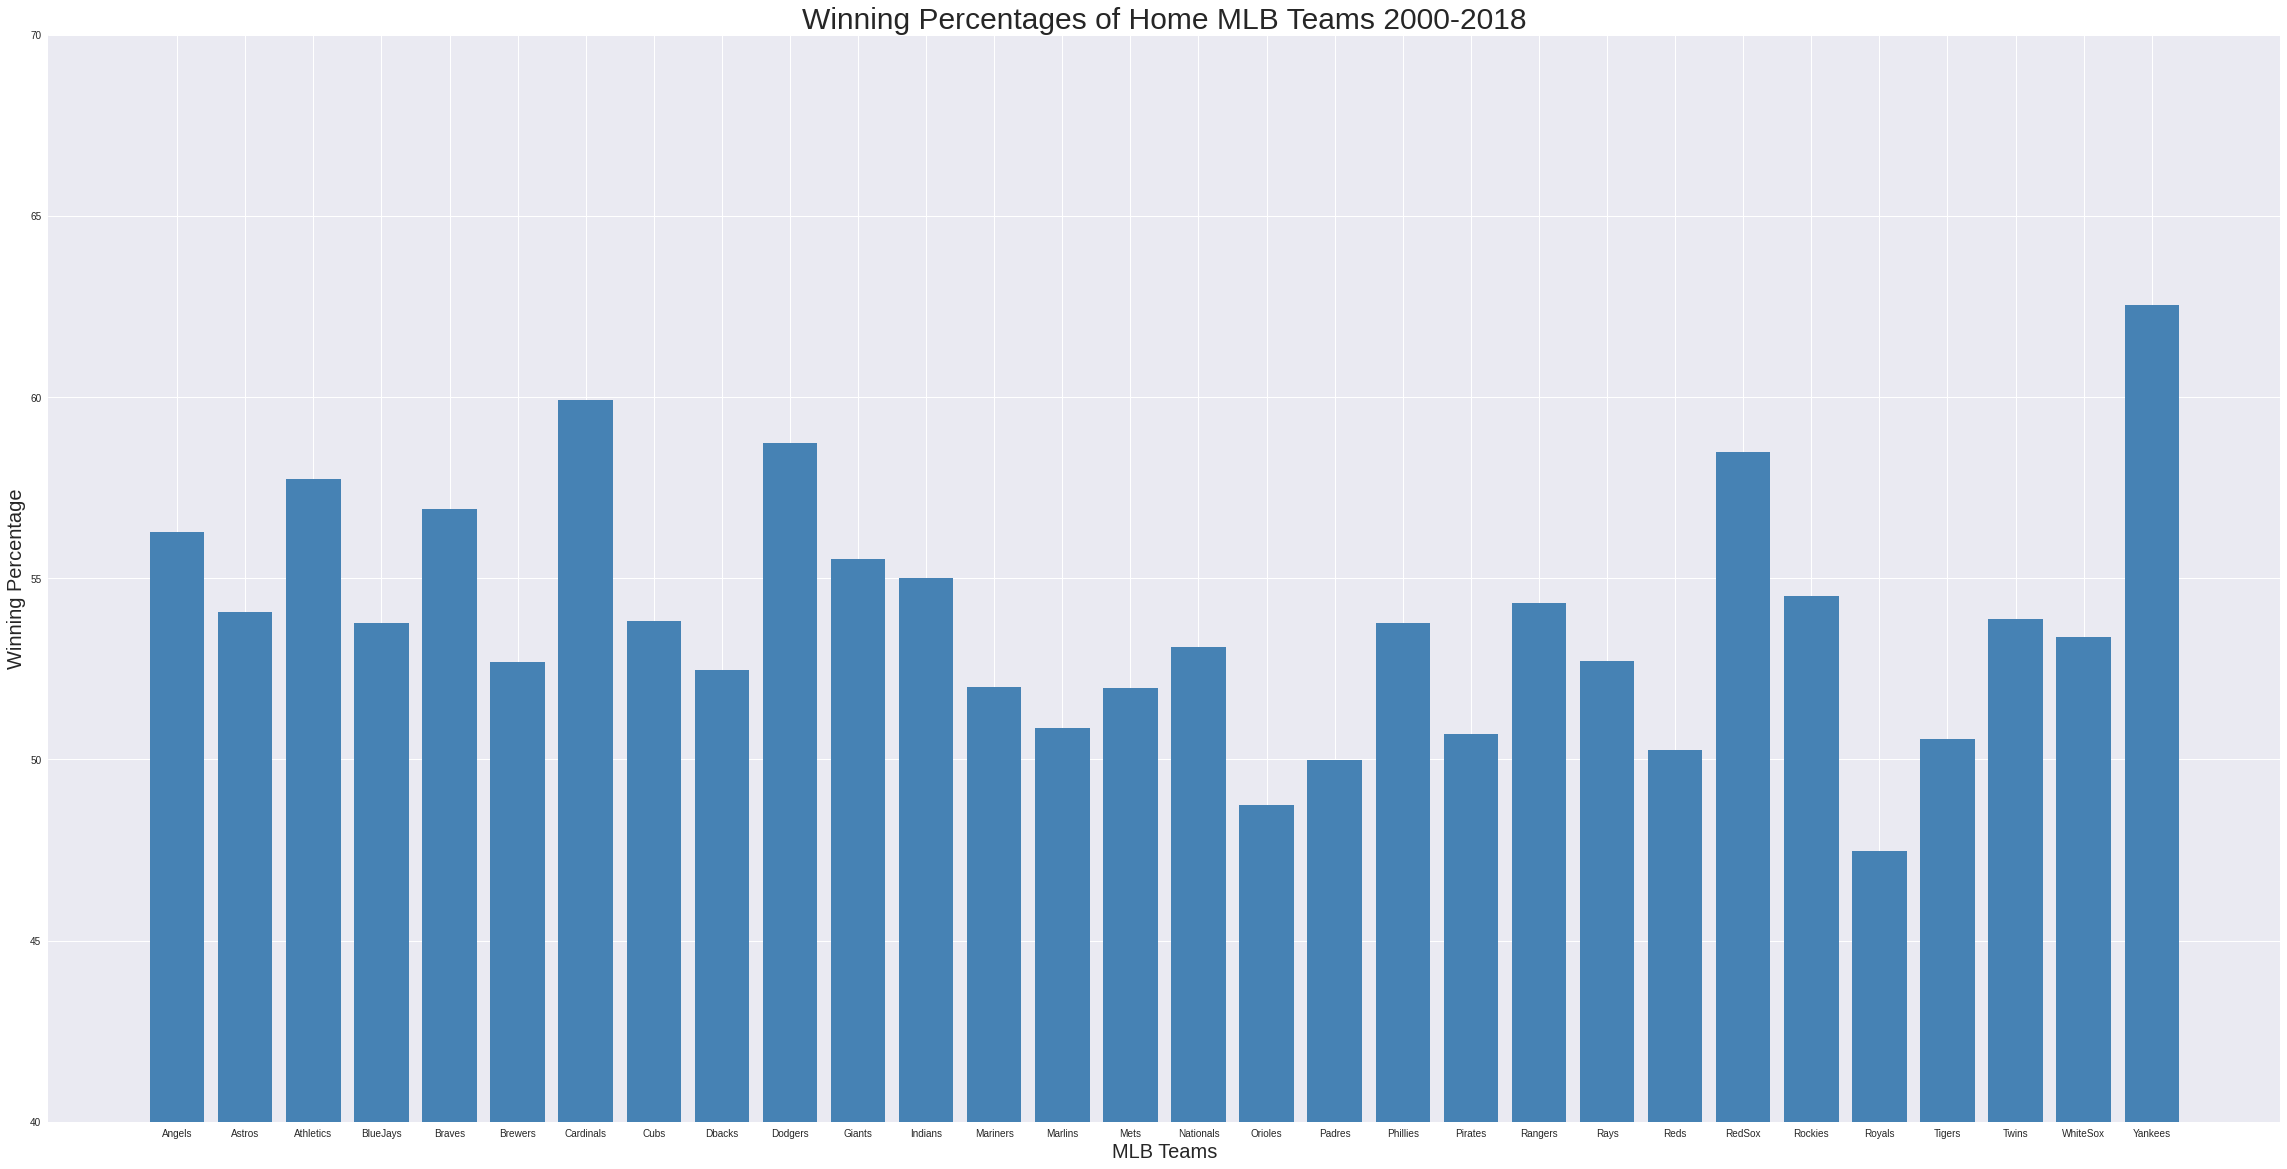

In [98]:
plt.bar(Team, Win_Per, color='steelblue')
# setting font sizeto 30
# using rc function
low = 40
high = 70
plt.ylim(low, high)

SMALL_SIZE = 14
LARGE_SIZE = 18
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=LARGE_SIZE)
plt.gcf().set_size_inches((40,20))
plt.title('Winning Percentages of Home MLB Teams 2000-2018', fontsize = 30)
plt.xlabel('MLB Teams', fontsize=20)
plt.ylabel('Winning Percentage', fontsize=20)
plt.show()

In [99]:
#df_WinPer_Model.to_csv(r'/content/df_WinPer_Model.csv', index = True)

In [100]:
from sklearn.metrics import f1_score, make_scorer, classification_report

scorer = make_scorer(f1_score, pos_label=None, average='weighted')

In [101]:
#My class values for each MLB Team
y_true_Angels = df_Angels["HomeWin"].values
y_true_Astros = df_Astros["HomeWin"].values
y_true_Athletics = df_Athletics["HomeWin"].values
y_true_BlueJays = df_BlueJays["HomeWin"].values
y_true_Braves = df_Braves["HomeWin"].values
y_true_Brewers = df_Brewers["HomeWin"].values
y_true_Cardinals = df_Cardinals["HomeWin"].values
y_true_Cubs = df_Cubs["HomeWin"].values
y_true_DBacks = df_DBacks["HomeWin"].values
y_true_Dodgers = df_Dodgers["HomeWin"].values
y_true_Giants = df_Giants["HomeWin"].values
y_true_Indians = df_Indians["HomeWin"].values
y_true_Mariners = df_Mariners["HomeWin"].values
y_true_Marlins = df_Marlins["HomeWin"].values
y_true_Mets = df_Mets["HomeWin"].values
y_true_Nationals = df_Nationals["HomeWin"].values
y_true_Orioles = df_Orioles["HomeWin"].values
y_true_Padres = df_Padres["HomeWin"].values
y_true_Phillies = df_Phillies["HomeWin"].values
y_true_Pirates = df_Pirates["HomeWin"].values
y_true_Rangers = df_Rangers["HomeWin"].values
y_true_Rays = df_Rays["HomeWin"].values
y_true_RedSox = df_RedSox["HomeWin"].values
y_true_Reds = df_Reds["HomeWin"].values
y_true_Rockies = df_Rockies["HomeWin"].values
y_true_Royals = df_Royals["HomeWin"].values
y_true_Tigers = df_Tigers["HomeWin"].values
y_true_Twins = df_Twins["HomeWin"].values
y_true_WhiteSox = df_WhiteSox["HomeWin"].values
y_true_Yankees = df_Yankees["HomeWin"].values

In [102]:
#Create a "basic" classifer
y_pred = [1] * len(y_true_Angels)
print ("Angels " "F1: {:.4f}".format(f1_score(y_true_Angels, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Astros)
print ("Astros " "F1: {:.4f}".format(f1_score(y_true_Astros, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Athletics)
print ("Athletics " "F1: {:.4f}".format(f1_score(y_true_Athletics, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_BlueJays)
print ("BlueJays " "F1: {:.4f}".format(f1_score(y_true_BlueJays, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Braves)
print ("Braves " "F1: {:.4f}".format(f1_score(y_true_Braves, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Brewers)
print ("Brewers ""F1: {:.4f}".format(f1_score(y_true_Brewers, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Cardinals)
print ("Cardinals ""F1: {:.4f}".format(f1_score(y_true_Cardinals, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Cubs)
print ("Cubs ""F1: {:.4f}".format(f1_score(y_true_Cubs, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_DBacks)
print ("DBacks ""F1: {:.4f}".format(f1_score(y_true_DBacks, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Dodgers)
print ("Dodgers ""F1: {:.4f}".format(f1_score(y_true_Dodgers, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Giants)
print ("Giants ""F1: {:.4f}".format(f1_score(y_true_Giants, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Indians)
print ("Indians ""F1: {:.4f}".format(f1_score(y_true_Indians, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Mariners)
print ("Mariners ""F1: {:.4f}".format(f1_score(y_true_Mariners, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Marlins)
print ("Marlins ""F1: {:.4f}".format(f1_score(y_true_Marlins, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Mets)
print ("Mets ""F1: {:.4f}".format(f1_score(y_true_Mets, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Nationals)
print ("Nationals ""F1: {:.4f}".format(f1_score(y_true_Nationals, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Orioles)
print ("Orioles ""F1: {:.4f}".format(f1_score(y_true_Orioles, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Padres)
print ("Padres ""F1: {:.4f}".format(f1_score(y_true_Padres, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Phillies)
print ("Phillies ""F1: {:.4f}".format(f1_score(y_true_Phillies, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Pirates)
print ("Pirates ""F1: {:.4f}".format(f1_score(y_true_Pirates, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Rangers)
print ("Rangers ""F1: {:.4f}".format(f1_score(y_true_Rangers, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Rays)
print ("Rays ""F1: {:.4f}".format(f1_score(y_true_Rays, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Reds)
print ("Reds ""F1: {:.4f}".format(f1_score(y_true_Reds, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_RedSox)
print ("RedSox ""F1: {:.4f}".format(f1_score(y_true_RedSox, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Rockies)
print ("Rockies ""F1: {:.4f}".format(f1_score(y_true_Rockies, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Royals)
print ("Royals ""F1: {:.4f}".format(f1_score(y_true_Royals, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Tigers)
print ("Tigers ""F1: {:.4f}".format(f1_score(y_true_Tigers, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Twins)
print ("Twins ""F1: {:.4f}".format(f1_score(y_true_Twins, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_WhiteSox)
print ("WhiteSox ""F1: {:.4f}".format(f1_score(y_true_WhiteSox, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")
print(" ")

#Create a "basic" classifer
y_pred = [1] * len(y_true_Yankees)
print ("Yankees ""F1: {:.4f}".format(f1_score(y_true_Yankees, y_pred, pos_label=None, average='weighted')))
print ("This is not very good we must do better!!!")

Angels F1: 0.4052
This is not very good we must do better!!!
 
Astros F1: 0.3796
This is not very good we must do better!!!
 
Athletics F1: 0.4227
This is not very good we must do better!!!
 
BlueJays F1: 0.3761
This is not very good we must do better!!!
 
Braves F1: 0.4128
This is not very good we must do better!!!
 
Brewers F1: 0.3636
This is not very good we must do better!!!
 
Cardinals F1: 0.4491
This is not very good we must do better!!!
 
Cubs F1: 0.3766
This is not very good we must do better!!!
 
DBacks F1: 0.3612
This is not very good we must do better!!!
 
Dodgers F1: 0.4346
This is not very good we must do better!!!
 
Giants F1: 0.3967
This is not very good we must do better!!!
 
Indians F1: 0.3904
This is not very good we must do better!!!
 
Mariners F1: 0.3558
This is not very good we must do better!!!
 
Marlins F1: 0.3431
This is not very good we must do better!!!
 
Mets F1: 0.3554
This is not very good we must do better!!!
 
Nationals F1: 0.3682
This is not very good we

In [103]:
#Creating some more features
df_MLB_HomeTeams["HomeLastWin"] = 0

df_MLB_HomeTeamsRanked["HomeLastWin"] = 0

In [104]:
for i in range(1, len(df_MLB_HomeTeams)):
  if df_MLB_HomeTeams.iloc[(i-1), 4] == 1: 
    df_MLB_HomeTeams.iloc[i, 5] = True

In [105]:
df_MLB_HomeTeams

,Result,HomeTeam,Runs,RA,HomeWin,HomeLastWin
0,0.0,1.0,2.0,3.0,0,0
1,0.0,1.0,3.0,5.0,0,0
2,1.0,1.0,12.0,6.0,1,0
4,1.0,1.0,7.0,3.0,1,True
5,1.0,1.0,7.0,5.0,1,True
...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,0,True
3604,1.0,1.0,9.0,1.0,1,0
3605,0.0,1.0,3.0,4.0,0,True
3606,1.0,1.0,7.0,2.0,1,0


In [106]:
for i in range(1, len(df_MLB_HomeTeamsRanked)):
  if df_MLB_HomeTeamsRanked.iloc[(i-1), 6] == 1: 
    df_MLB_HomeTeamsRanked.iloc[i, 7] = True

In [107]:
df_MLB_HomeTeamsRanked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin,HomeLastWin
0,0.0,1.0,2.0,3.0,18,LAA,0,0
1,0.0,1.0,3.0,5.0,18,LAA,0,0
2,1.0,1.0,12.0,6.0,18,LAA,1,0
4,1.0,1.0,7.0,3.0,18,LAA,1,True
5,1.0,1.0,7.0,5.0,18,LAA,1,True
...,...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,12,NYY,0,True
3604,1.0,1.0,9.0,1.0,12,NYY,1,0
3605,0.0,1.0,3.0,4.0,12,NYY,0,True
3606,1.0,1.0,7.0,2.0,12,NYY,1,0


In [108]:
#df_MLB_HomeTeams.to_csv(r'/content/df_HomelastWin.csv', index = False)

In [109]:
df_MLB_HomeTeams["HomeLastWin"] = df_MLB_HomeTeams["HomeLastWin"].astype(int)
df_MLB_HomeTeamsRanked["HomeLastWin"] = df_MLB_HomeTeamsRanked["HomeLastWin"].astype(int)

In [110]:
df_MLB_HomeTeams

,Result,HomeTeam,Runs,RA,HomeWin,HomeLastWin
0,0.0,1.0,2.0,3.0,0,0
1,0.0,1.0,3.0,5.0,0,0
2,1.0,1.0,12.0,6.0,1,0
4,1.0,1.0,7.0,3.0,1,1
5,1.0,1.0,7.0,5.0,1,1
...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,0,1
3604,1.0,1.0,9.0,1.0,1,0
3605,0.0,1.0,3.0,4.0,0,1
3606,1.0,1.0,7.0,2.0,1,0


In [111]:
df_MLB_HomeTeamsRanked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin,HomeLastWin
0,0.0,1.0,2.0,3.0,18,LAA,0,0
1,0.0,1.0,3.0,5.0,18,LAA,0,0
2,1.0,1.0,12.0,6.0,18,LAA,1,0
4,1.0,1.0,7.0,3.0,18,LAA,1,1
5,1.0,1.0,7.0,5.0,18,LAA,1,1
...,...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,12,NYY,0,1
3604,1.0,1.0,9.0,1.0,12,NYY,1,0
3605,0.0,1.0,3.0,4.0,12,NYY,0,1
3606,1.0,1.0,7.0,2.0,12,NYY,1,0


In [112]:
#Creating some more features
df_MLB_HomeTeams["VisitorLastWin"] = 1

df_MLB_HomeTeamsRanked["VisitorLastWin"] = 1

In [113]:
df_MLB_HomeTeams

,Result,HomeTeam,Runs,RA,HomeWin,HomeLastWin,VisitorLastWin
0,0.0,1.0,2.0,3.0,0,0,1
1,0.0,1.0,3.0,5.0,0,0,1
2,1.0,1.0,12.0,6.0,1,0,1
4,1.0,1.0,7.0,3.0,1,1,1
5,1.0,1.0,7.0,5.0,1,1,1
...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,0,1,1
3604,1.0,1.0,9.0,1.0,1,0,1
3605,0.0,1.0,3.0,4.0,0,1,1
3606,1.0,1.0,7.0,2.0,1,0,1


In [114]:
df_MLB_HomeTeamsRanked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin,HomeLastWin,VisitorLastWin
0,0.0,1.0,2.0,3.0,18,LAA,0,0,1
1,0.0,1.0,3.0,5.0,18,LAA,0,0,1
2,1.0,1.0,12.0,6.0,18,LAA,1,0,1
4,1.0,1.0,7.0,3.0,18,LAA,1,1,1
5,1.0,1.0,7.0,5.0,18,LAA,1,1,1
...,...,...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,12,NYY,0,1,1
3604,1.0,1.0,9.0,1.0,12,NYY,1,0,1
3605,0.0,1.0,3.0,4.0,12,NYY,0,1,1
3606,1.0,1.0,7.0,2.0,12,NYY,1,0,1


In [115]:
for i in range(1, len(df_MLB_HomeTeams)):
  if df_MLB_HomeTeams.iloc[i, 5] == 1: 
    df_MLB_HomeTeams.iloc[i, 6] = False

In [116]:
for i in range(1, len(df_MLB_HomeTeamsRanked)):
  if df_MLB_HomeTeamsRanked.iloc[i, 7] == 1: 
    df_MLB_HomeTeamsRanked.iloc[i, 8] = False

In [117]:
df_MLB_HomeTeams["VisitorLastWin"] = df_MLB_HomeTeams["VisitorLastWin"].astype(int)

df_MLB_HomeTeamsRanked["VisitorLastWin"] = df_MLB_HomeTeams["VisitorLastWin"].astype(int)

In [118]:
# Basic classification with a decision tree
from sklearn.tree import DecisionTreeClassifier

In [119]:
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

# Create a dataset with just the necessary information
y_true = df_MLB_HomeTeams["HomeWin"].values
X_previouswins = df_MLB_HomeTeams[["HomeLastWin", "VisitorLastWin"]].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_previouswins, y_true, scoring=scorer)
print("Using just the last game result from the home and visitor teams")
print("F1: {0:.4f}".format(np.mean(scores)))

Using just the last game result from the home and visitor teams
F1: 0.3772


In [120]:
#Creating some more features
#df_MLB_HomeTeams["HomeTeam_HighScoring"] = False

In [121]:
'''
xls = pd.ExcelFile('/content/Baseball_Pitching_Stats_Updated.xlsx')
df_Pitch2000 = pd.read_excel(xls, '2000_Season')
df_Pitch2001 = pd.read_excel(xls, '2001_Season')
df_Pitch2002 = pd.read_excel(xls, '2002_Season')
df_Pitch2003 = pd.read_excel(xls, '2003_Season')
df_Pitch2004 = pd.read_excel(xls, '2004_Season')
df_Pitch2005 = pd.read_excel(xls, '2005_Season')
df_Pitch2006 = pd.read_excel(xls, '2006_Season')
df_Pitch2007 = pd.read_excel(xls, '2007_Season')
df_Pitch2008 = pd.read_excel(xls, '2008_Season')
df_Pitch2009 = pd.read_excel(xls, '2009_Season')
df_Pitch2010 = pd.read_excel(xls, '2010_Season')
df_Pitch2011 = pd.read_excel(xls, '2011_Season')
df_Pitch2012 = pd.read_excel(xls, '2012_Season')
df_Pitch2013 = pd.read_excel(xls, '2013_Season')
df_Pitch2014 = pd.read_excel(xls, '2014_Season')
df_Pitch2015 = pd.read_excel(xls, '2015_Season')
df_Pitch2016 = pd.read_excel(xls, '2016_Season')
df_Pitch2017 = pd.read_excel(xls, '2017_Season')
df_Pitch2018 = pd.read_excel(xls, '2018_Season')
df_Pitch2019 = pd.read_excel(xls, '2019_Season')
'''

"\nxls = pd.ExcelFile('/content/Baseball_Pitching_Stats_Updated.xlsx')\ndf_Pitch2000 = pd.read_excel(xls, '2000_Season')\ndf_Pitch2001 = pd.read_excel(xls, '2001_Season')\ndf_Pitch2002 = pd.read_excel(xls, '2002_Season')\ndf_Pitch2003 = pd.read_excel(xls, '2003_Season')\ndf_Pitch2004 = pd.read_excel(xls, '2004_Season')\ndf_Pitch2005 = pd.read_excel(xls, '2005_Season')\ndf_Pitch2006 = pd.read_excel(xls, '2006_Season')\ndf_Pitch2007 = pd.read_excel(xls, '2007_Season')\ndf_Pitch2008 = pd.read_excel(xls, '2008_Season')\ndf_Pitch2009 = pd.read_excel(xls, '2009_Season')\ndf_Pitch2010 = pd.read_excel(xls, '2010_Season')\ndf_Pitch2011 = pd.read_excel(xls, '2011_Season')\ndf_Pitch2012 = pd.read_excel(xls, '2012_Season')\ndf_Pitch2013 = pd.read_excel(xls, '2013_Season')\ndf_Pitch2014 = pd.read_excel(xls, '2014_Season')\ndf_Pitch2015 = pd.read_excel(xls, '2015_Season')\ndf_Pitch2016 = pd.read_excel(xls, '2016_Season')\ndf_Pitch2017 = pd.read_excel(xls, '2017_Season')\ndf_Pitch2018 = pd.read_excel

In [122]:
xls = pd.ExcelFile('/content/Baseball_Batting_Stats_updated.xlsx')
df_Batting2000 = pd.read_excel(xls, '2000_Season')
df_Batting2001 = pd.read_excel(xls, '2001_Season')
df_Batting2002 = pd.read_excel(xls, '2002_Season')
df_Batting2003 = pd.read_excel(xls, '2003_Season')
df_Batting2004 = pd.read_excel(xls, '2004_Season')
df_Batting2005 = pd.read_excel(xls, '2005_Season')
df_Batting2006 = pd.read_excel(xls, '2006_Season')
df_Batting2007 = pd.read_excel(xls, '2007_Season')
df_Batting2008 = pd.read_excel(xls, '2008_Season')
df_Batting2009 = pd.read_excel(xls, '2009_Season')
df_Batting2010 = pd.read_excel(xls, '2010_Season')
df_Batting2011 = pd.read_excel(xls, '2011_Season')
df_Batting2012 = pd.read_excel(xls, '2012_Season')
df_Batting2013 = pd.read_excel(xls, '2013_Season')
df_Batting2014 = pd.read_excel(xls, '2014_Season')
df_Batting2015 = pd.read_excel(xls, '2015_Season')
df_Batting2016 = pd.read_excel(xls, '2016_Season')
df_Batting2017 = pd.read_excel(xls, '2017_Season')
df_Batting2018 = pd.read_excel(xls, '2018_Season')
df_Batting2019 = pd.read_excel(xls, '2019_Season')

In [123]:
'''
df_PitchStats = df_Pitch2000.append(df_Pitch2001)
df_PitchStats = df_PitchStats.append(df_Pitch2002)
df_PitchStats = df_PitchStats.append(df_Pitch2003)
df_PitchStats = df_PitchStats.append(df_Pitch2004)
df_PitchStats = df_PitchStats.append(df_Pitch2005)
df_PitchStats = df_PitchStats.append(df_Pitch2006)
df_PitchStats = df_PitchStats.append(df_Pitch2007)
df_PitchStats = df_PitchStats.append(df_Pitch2008)
df_PitchStats = df_PitchStats.append(df_Pitch2009)
df_PitchStats = df_PitchStats.append(df_Pitch2010)
df_PitchStats = df_PitchStats.append(df_Pitch2011)
df_PitchStats = df_PitchStats.append(df_Pitch2012)
df_PitchStats = df_PitchStats.append(df_Pitch2013)
df_PitchStats = df_PitchStats.append(df_Pitch2014)
df_PitchStats = df_PitchStats.append(df_Pitch2015)
df_PitchStats = df_PitchStats.append(df_Pitch2016)
df_PitchStats = df_PitchStats.append(df_Pitch2017)
df_PitchStats = df_PitchStats.append(df_Pitch2018)
df_PitchStats = df_PitchStats.append(df_Pitch2019)
'''

'\ndf_PitchStats = df_Pitch2000.append(df_Pitch2001)\ndf_PitchStats = df_PitchStats.append(df_Pitch2002)\ndf_PitchStats = df_PitchStats.append(df_Pitch2003)\ndf_PitchStats = df_PitchStats.append(df_Pitch2004)\ndf_PitchStats = df_PitchStats.append(df_Pitch2005)\ndf_PitchStats = df_PitchStats.append(df_Pitch2006)\ndf_PitchStats = df_PitchStats.append(df_Pitch2007)\ndf_PitchStats = df_PitchStats.append(df_Pitch2008)\ndf_PitchStats = df_PitchStats.append(df_Pitch2009)\ndf_PitchStats = df_PitchStats.append(df_Pitch2010)\ndf_PitchStats = df_PitchStats.append(df_Pitch2011)\ndf_PitchStats = df_PitchStats.append(df_Pitch2012)\ndf_PitchStats = df_PitchStats.append(df_Pitch2013)\ndf_PitchStats = df_PitchStats.append(df_Pitch2014)\ndf_PitchStats = df_PitchStats.append(df_Pitch2015)\ndf_PitchStats = df_PitchStats.append(df_Pitch2016)\ndf_PitchStats = df_PitchStats.append(df_Pitch2017)\ndf_PitchStats = df_PitchStats.append(df_Pitch2018)\ndf_PitchStats = df_PitchStats.append(df_Pitch2019)\n'

In [124]:
#df_PitchStats.Tm[0:30]

In [125]:
#df_PitchStats_AvgStats = pd.DataFrame(df_PitchStats, columns = ['Tm', 'R', 'RA9', 'WAR', 'RAR'])

In [126]:
#To select rows whose column value equals a scalar, some_value, use ==:
'''
df_PitchAngels = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Angels']
df_PitchDbacks = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Dbacks']
df_PitchBraves = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Braves']
df_PitchOrioles = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Orioles']
df_PitchRedSox = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'RedSox']
df_PitchCubs = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Cubs']
df_PitchWhiteSox = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'WhiteSox']
df_PitchReds = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Reds']
df_PitchIndians = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Indians']
df_PitchRockies = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Rockies']
df_PitchTigers = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Tigers']
df_PitchMarlins = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Marlins']
df_PitchAstros = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Astros']
df_PitchRoyals = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Royals']
df_PitchDodgers = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Dodgers']
df_PitchBrewers = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Brewers']
df_PitchTwins = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Twins']
df_PitchNationals = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Nationals']
df_PitchMets = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Mets']
df_PitchYankees = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Yankees']
df_PitchAthletics = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Athletics']
df_PitchPhillies = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Phillies']
df_PitchPirates = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Pirates']
df_PitchPadres = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Padres']
df_PitchMariners = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Mariners']
df_PitchGiants = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Giants']
df_PitchCardinals = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Cardinals']
df_PitchRays = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Rays']
df_PitchRangers = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Rangers']
df_PitchBlueJays = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'BlueJays']
'''

"\ndf_PitchAngels = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Angels']\ndf_PitchDbacks = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Dbacks']\ndf_PitchBraves = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Braves']\ndf_PitchOrioles = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Orioles']\ndf_PitchRedSox = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'RedSox']\ndf_PitchCubs = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Cubs']\ndf_PitchWhiteSox = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'WhiteSox']\ndf_PitchReds = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Reds']\ndf_PitchIndians = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Indians']\ndf_PitchRockies = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Rockies']\ndf_PitchTigers = df_PitchStats_AvgStats.loc[df_PitchStats_AvgStats['Tm'] == 'Tigers']\ndf_PitchMarlins = df_PitchStats_AvgSta

In [127]:
'''
df_PitchAngels_AVG = df_PitchAngels.mean(axis=0)
df_PitchDbacks_AVG = df_PitchDbacks.mean(axis=0)
df_PitchBraves_AVG = df_PitchBraves.mean(axis=0)
df_PitchOrioles_AVG = df_PitchOrioles.mean(axis=0)
df_PitchRedSox_AVG = df_PitchRedSox.mean(axis=0)
df_PitchCubs_AVG = df_PitchCubs.mean(axis=0)
df_PitchWhiteSox_AVG = df_PitchWhiteSox.mean(axis=0)
df_PitchReds_AVG = df_PitchReds.mean(axis=0)
df_PitchIndians_AVG = df_PitchIndians.mean(axis=0)
df_PitchRockies_AVG = df_PitchRockies.mean(axis=0)
df_PitchTigers_AVG = df_PitchTigers.mean(axis=0)
df_PitchMarlins_AVG = df_PitchMarlins.mean(axis=0)
df_PitchAstros_AVG = df_PitchAstros.mean(axis=0)
df_PitchRoyals_AVG = df_PitchRoyals.mean(axis=0)
df_PitchDodgers_AVG = df_PitchDodgers.mean(axis=0)
df_PitchBrewers_AVG = df_PitchBrewers.mean(axis=0)
df_PitchTwins_AVG = df_PitchTwins.mean(axis=0)
df_PitchNationals_AVG = df_PitchNationals.mean(axis=0)
df_PitchMets_AVG = df_PitchMets.mean(axis=0)
df_PitchYankees_AVG = df_PitchYankees.mean(axis=0)
df_PitchAthletics_AVG = df_PitchAthletics.mean(axis=0)
df_PitchPhillies_AVG = df_PitchPhillies.mean(axis=0)
df_PitchPirates_AVG = df_PitchPirates.mean(axis=0)
df_PitchPadres_AVG = df_PitchPadres.mean(axis=0)
df_PitchMariners_AVG = df_PitchMariners.mean(axis=0)
df_PitchGiants_AVG = df_PitchGiants.mean(axis=0)
df_PitchCardinals_AVG = df_PitchCardinals.mean(axis=0)
df_PitchRays_AVG = df_PitchRays.mean(axis=0)
df_PitchRangers_AVG = df_PitchRangers.mean(axis=0)
df_PitchBlueJays_AVG = df_PitchBlueJays.mean(axis=0)
'''

'\ndf_PitchAngels_AVG = df_PitchAngels.mean(axis=0)\ndf_PitchDbacks_AVG = df_PitchDbacks.mean(axis=0)\ndf_PitchBraves_AVG = df_PitchBraves.mean(axis=0)\ndf_PitchOrioles_AVG = df_PitchOrioles.mean(axis=0)\ndf_PitchRedSox_AVG = df_PitchRedSox.mean(axis=0)\ndf_PitchCubs_AVG = df_PitchCubs.mean(axis=0)\ndf_PitchWhiteSox_AVG = df_PitchWhiteSox.mean(axis=0)\ndf_PitchReds_AVG = df_PitchReds.mean(axis=0)\ndf_PitchIndians_AVG = df_PitchIndians.mean(axis=0)\ndf_PitchRockies_AVG = df_PitchRockies.mean(axis=0)\ndf_PitchTigers_AVG = df_PitchTigers.mean(axis=0)\ndf_PitchMarlins_AVG = df_PitchMarlins.mean(axis=0)\ndf_PitchAstros_AVG = df_PitchAstros.mean(axis=0)\ndf_PitchRoyals_AVG = df_PitchRoyals.mean(axis=0)\ndf_PitchDodgers_AVG = df_PitchDodgers.mean(axis=0)\ndf_PitchBrewers_AVG = df_PitchBrewers.mean(axis=0)\ndf_PitchTwins_AVG = df_PitchTwins.mean(axis=0)\ndf_PitchNationals_AVG = df_PitchNationals.mean(axis=0)\ndf_PitchMets_AVG = df_PitchMets.mean(axis=0)\ndf_PitchYankees_AVG = df_PitchYankees.m

In [128]:
# create an Empty DataFrame
# object With column names only
#df_PitchingAVG = pd.DataFrame(columns = ['R', 'RA9', 'WAR', 'RAR'], index=[df_PitchStats.Tm[0:30]])
#dfObj = pd.DataFrame(columns=['User_ID', 'UserName', 'Action'], index=['a', 'b', 'c'])
#print(df_PitchingAVG)

In [129]:
# adding rows to an empty 
# dataframe at existing index
'''
df_PitchingAVG.loc['Twins'] = [df_PitchTwins_AVG]
df_PitchingAVG.loc['Nationals'] = [df_PitchNationals_AVG]
df_PitchingAVG.loc['Mets'] = [df_PitchMets_AVG]
df_PitchingAVG.loc['Yankees'] = [df_PitchYankees_AVG]
df_PitchingAVG.loc['Athletics'] = [df_PitchAthletics_AVG]
df_PitchingAVG.loc['Phillies'] = [df_PitchPhillies_AVG]
df_PitchingAVG.loc['Pirates'] = [df_PitchPirates_AVG]
df_PitchingAVG.loc['Padres'] = [df_PitchPadres_AVG]
df_PitchingAVG.loc['Mariners'] = [df_PitchMariners_AVG]
df_PitchingAVG.loc['Giants'] = [df_PitchGiants_AVG]
df_PitchingAVG.loc['Cardinals'] = [df_PitchCardinals_AVG]
df_PitchingAVG.loc['Rays'] = [df_PitchRays_AVG]
df_PitchingAVG.loc['Rangers'] = [df_PitchRangers_AVG]
df_PitchingAVG.loc['BlueJays'] = [df_PitchBlueJays_AVG]
'''

"\ndf_PitchingAVG.loc['Twins'] = [df_PitchTwins_AVG]\ndf_PitchingAVG.loc['Nationals'] = [df_PitchNationals_AVG]\ndf_PitchingAVG.loc['Mets'] = [df_PitchMets_AVG]\ndf_PitchingAVG.loc['Yankees'] = [df_PitchYankees_AVG]\ndf_PitchingAVG.loc['Athletics'] = [df_PitchAthletics_AVG]\ndf_PitchingAVG.loc['Phillies'] = [df_PitchPhillies_AVG]\ndf_PitchingAVG.loc['Pirates'] = [df_PitchPirates_AVG]\ndf_PitchingAVG.loc['Padres'] = [df_PitchPadres_AVG]\ndf_PitchingAVG.loc['Mariners'] = [df_PitchMariners_AVG]\ndf_PitchingAVG.loc['Giants'] = [df_PitchGiants_AVG]\ndf_PitchingAVG.loc['Cardinals'] = [df_PitchCardinals_AVG]\ndf_PitchingAVG.loc['Rays'] = [df_PitchRays_AVG]\ndf_PitchingAVG.loc['Rangers'] = [df_PitchRangers_AVG]\ndf_PitchingAVG.loc['BlueJays'] = [df_PitchBlueJays_AVG]\n"

In [130]:
#df_PitchingAVG.to_csv(r'/content/df_MLB_PitchingStatsAVG.csv', index = True)

In [131]:
#df_MLB_Pitching_Ranking = pd.read_csv('/content/MLB_Pitching_Ranking.csv')

In [132]:
df_BattingStats = df_Batting2000.append(df_Batting2001)
df_BattingStats = df_BattingStats.append(df_Batting2002)
df_BattingStats = df_BattingStats.append(df_Batting2003)
df_BattingStats = df_BattingStats.append(df_Batting2004)
df_BattingStats = df_BattingStats.append(df_Batting2005)
df_BattingStats = df_BattingStats.append(df_Batting2006)
df_BattingStats = df_BattingStats.append(df_Batting2007)
df_BattingStats = df_BattingStats.append(df_Batting2008)
df_BattingStats = df_BattingStats.append(df_Batting2009)
df_BattingStats = df_BattingStats.append(df_Batting2010)
df_BattingStats = df_BattingStats.append(df_Batting2011)
df_BattingStats = df_BattingStats.append(df_Batting2012)
df_BattingStats = df_BattingStats.append(df_Batting2013)
df_BattingStats = df_BattingStats.append(df_Batting2014)
df_BattingStats = df_BattingStats.append(df_Batting2015)
df_BattingStats = df_BattingStats.append(df_Batting2016)
df_BattingStats = df_BattingStats.append(df_Batting2017)
df_BattingStats = df_BattingStats.append(df_Batting2018)
df_BattingStats = df_BattingStats.append(df_Batting2019)

In [133]:
df_BattingStats

,Tm,R/G,Outs,RC,RC/G,AIR,BAbip,BA,lgBA,OBP,lgOBP,SLG,lgSLG,OPS,lgOPS,OPS+,OWn%,BtRuns,BtWins,TotA,SecA,ISO,PwrSpd
0,Angels,5.33,4322,953,5.9,117,0.303,0.280,0.279,0.352,0.352,0.472,0.448,0.825,0.800,105,0.529,39.4,3.3,0.805,0.308,0.193,133.4
1,Dbacks,4.89,4338,829,5.1,120,0.290,0.265,0.278,0.333,0.356,0.429,0.454,0.763,0.810,88,0.481,-116.0,-10.8,0.726,0.270,0.164,125.8
2,Braves,5.00,4314,856,5.3,116,0.302,0.271,0.273,0.346,0.351,0.429,0.446,0.775,0.797,95,0.498,-45.1,-4.3,0.754,0.282,0.157,162.0
3,Orioles,4.90,4335,832,5.1,111,0.293,0.272,0.270,0.341,0.342,0.435,0.435,0.776,0.777,100,0.466,5.2,0.3,0.740,0.275,0.163,149.6
4,RedSox,4.89,4360,852,5.2,118,0.297,0.267,0.280,0.341,0.353,0.423,0.450,0.764,0.803,90,0.474,-88.3,-8.2,0.721,0.267,0.156,68.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Cardinals,4.72,4331,764,4.7,106,0.292,0.245,0.252,0.322,0.324,0.415,0.435,0.737,0.759,95,0.478,-34.9,-3.4,0.709,0.288,0.170,149.4
26,Rays,4.75,4394,810,4.9,102,0.306,0.254,0.248,0.325,0.317,0.431,0.430,0.757,0.747,103,0.493,32.8,2.9,0.721,0.284,0.178,131.2
27,Rangers,5.00,4363,799,4.9,116,0.304,0.248,0.266,0.319,0.337,0.431,0.461,0.750,0.798,88,0.490,-105.5,-10.2,0.725,0.296,0.183,165.0
28,BlueJays,4.48,4363,733,4.5,104,0.280,0.236,0.250,0.305,0.319,0.428,0.434,0.733,0.753,94,0.450,-48.6,-4.8,0.684,0.290,0.192,84.5


In [134]:
df_BatStats = pd.DataFrame(df_BattingStats, columns = ['Tm', 'R/G', 'RC/G', 'OBP', 'SLG'])

In [135]:
#df_BatStats['Team'] = df_PitchStats.Tm[0:30]
df_BatStats 

,Tm,R/G,RC/G,OBP,SLG
0,Angels,5.33,5.9,0.352,0.472
1,Dbacks,4.89,5.1,0.333,0.429
2,Braves,5.00,5.3,0.346,0.429
3,Orioles,4.90,5.1,0.341,0.435
4,RedSox,4.89,5.2,0.341,0.423
...,...,...,...,...,...
25,Cardinals,4.72,4.7,0.322,0.415
26,Rays,4.75,4.9,0.325,0.431
27,Rangers,5.00,4.9,0.319,0.431
28,BlueJays,4.48,4.5,0.305,0.428


In [136]:
df_BatAngels = df_BatStats.loc[df_BatStats['Tm'] == 'Angels']
df_BatDbacks = df_BatStats.loc[df_BatStats['Tm'] == 'Dbacks']
df_BatBraves = df_BatStats.loc[df_BatStats['Tm'] == 'Braves']
df_BatOrioles = df_BatStats.loc[df_BatStats['Tm'] == 'Orioles']
df_BatRedSox = df_BatStats.loc[df_BatStats['Tm'] == 'RedSox']
df_BatCubs = df_BatStats.loc[df_BatStats['Tm'] == 'Cubs']
df_BatWhiteSox = df_BatStats.loc[df_BatStats['Tm'] == 'WhiteSox']
df_BatReds = df_BatStats.loc[df_BatStats['Tm'] == 'Reds']
df_BatIndians = df_BatStats.loc[df_BatStats['Tm'] == 'Indians']
df_BatRockies = df_BatStats.loc[df_BatStats['Tm'] == 'Rockies']
df_BatTigers = df_BatStats.loc[df_BatStats['Tm'] == 'Tigers']
df_BatMarlins = df_BatStats.loc[df_BatStats['Tm'] == 'Marlins']
df_BatAstros = df_BatStats.loc[df_BatStats['Tm'] == 'Astros']
df_BatRoyals = df_BatStats.loc[df_BatStats['Tm'] == 'Royals']
df_BatDodgers = df_BatStats.loc[df_BatStats['Tm'] == 'Dodgers']
df_BatBrewers = df_BatStats.loc[df_BatStats['Tm'] == 'Brewers']
df_BatTwins = df_BatStats.loc[df_BatStats['Tm'] == 'Twins']
df_BatNationals = df_BatStats.loc[df_BatStats['Tm'] == 'Nationals']
df_BatMets = df_BatStats.loc[df_BatStats['Tm'] == 'Mets']
df_BatYankees = df_BatStats.loc[df_BatStats['Tm'] == 'Yankees']
df_BatAthletics = df_BatStats.loc[df_BatStats['Tm'] == 'Athletics']
df_BatPhillies = df_BatStats.loc[df_BatStats['Tm'] == 'Phillies']
df_BatPirates = df_BatStats.loc[df_BatStats['Tm'] == 'Pirates']
df_BatPadres = df_BatStats.loc[df_BatStats['Tm'] == 'Padres']
df_BatMariners = df_BatStats.loc[df_BatStats['Tm'] == 'Mariners']
df_BatGiants = df_BatStats.loc[df_BatStats['Tm'] == 'Giants']
df_BatCardinals = df_BatStats.loc[df_BatStats['Tm'] == 'Cardinals']
df_BatRays = df_BatStats.loc[df_BatStats['Tm'] == 'Rays']
df_BatRangers = df_BatStats.loc[df_BatStats['Tm'] == 'Rangers']
df_BatBlueJays = df_BatStats.loc[df_BatStats['Tm'] == 'BlueJays']

In [137]:
df_BatAngels

,Tm,R/G,RC/G,OBP,SLG
0,Angels,5.33,5.9,0.352,0.472
0,Angels,4.27,4.6,0.327,0.405
0,Angels,5.25,5.3,0.341,0.433
0,Angels,4.54,4.7,0.330,0.413
0,Angels,5.16,5.3,0.341,0.429
13,Angels,4.70,4.6,0.325,0.409
13,Angels,4.73,5.0,0.334,0.425
13,Angels,5.07,5.1,0.345,0.417
13,Angels,4.72,4.7,0.330,0.413
13,Angels,5.45,5.5,0.350,0.441


In [138]:
df_BatsAngels_AVG = df_BatAngels.mean(axis=0)
df_BatsDbacks_AVG = df_BatDbacks.mean(axis=0)
df_BatsBraves_AVG = df_BatBraves.mean(axis=0)
df_BatsOrioles_AVG = df_BatOrioles.mean(axis=0)
df_BatsRedSox_AVG = df_BatRedSox.mean(axis=0)
df_BatsCubs_AVG = df_BatCubs.mean(axis=0)
df_BatsWhiteSox_AVG = df_BatWhiteSox.mean(axis=0)
df_BatsReds_AVG = df_BatReds.mean(axis=0)
df_BatsIndians_AVG = df_BatIndians.mean(axis=0)
df_BatsRockies_AVG = df_BatRockies.mean(axis=0)
df_BatsTigers_AVG = df_BatTigers.mean(axis=0)
df_BatsMarlins_AVG = df_BatMarlins.mean(axis=0)
df_BatsAstros_AVG = df_BatAstros.mean(axis=0)
df_BatsRoyals_AVG = df_BatRoyals.mean(axis=0)
df_BatsDodgers_AVG = df_BatDodgers.mean(axis=0)
df_BatsBrewers_AVG = df_BatBrewers.mean(axis=0)
df_BatsTwins_AVG = df_BatTwins.mean(axis=0)
df_BatsNationals_AVG = df_BatNationals.mean(axis=0)
df_BatsMets_AVG = df_BatMets.mean(axis=0)
df_BatsYankees_AVG = df_BatYankees.mean(axis=0)
df_BatsAthletics_AVG = df_BatAthletics.mean(axis=0)
df_BatsPhillies_AVG = df_BatPhillies.mean(axis=0)
df_BatsPirates_AVG = df_BatPirates.mean(axis=0)
df_BatsPadres_AVG = df_BatPadres.mean(axis=0)
df_BatsMariners_AVG = df_BatMariners.mean(axis=0)
df_BatsGiants_AVG = df_BatGiants.mean(axis=0)
df_BatsCardinals_AVG = df_BatCardinals.mean(axis=0)
df_BatsRays_AVG = df_BatRays.mean(axis=0)
df_BatsRangers_AVG = df_BatRangers.mean(axis=0)
df_BatsBlueJays_AVG = df_BatBlueJays.mean(axis=0)

In [139]:
df_BatsAngels_AVG

R/G     4.68300
RC/G    4.90000
OBP     0.33125
SLG     0.41990
dtype: float64

In [140]:
# create an Empty DataFrame
# object With column names only
df_BattingAVG = pd.DataFrame(columns = ['R/G', 'RC/G', 'OBP', 'SLG'], index=[df_BatStats.Tm[0:30]])
print(df_BattingAVG)

           R/G RC/G  OBP  SLG
Tm                           
Angels     NaN  NaN  NaN  NaN
Dbacks     NaN  NaN  NaN  NaN
Braves     NaN  NaN  NaN  NaN
Orioles    NaN  NaN  NaN  NaN
RedSox     NaN  NaN  NaN  NaN
Cubs       NaN  NaN  NaN  NaN
WhiteSox   NaN  NaN  NaN  NaN
Reds       NaN  NaN  NaN  NaN
Indians    NaN  NaN  NaN  NaN
Rockies    NaN  NaN  NaN  NaN
Tigers     NaN  NaN  NaN  NaN
Marlins    NaN  NaN  NaN  NaN
Astros     NaN  NaN  NaN  NaN
Royals     NaN  NaN  NaN  NaN
Dodgers    NaN  NaN  NaN  NaN
Brewers    NaN  NaN  NaN  NaN
Twins      NaN  NaN  NaN  NaN
Nationals  NaN  NaN  NaN  NaN
Mets       NaN  NaN  NaN  NaN
Yankees    NaN  NaN  NaN  NaN
Athletics  NaN  NaN  NaN  NaN
Phillies   NaN  NaN  NaN  NaN
Pirates    NaN  NaN  NaN  NaN
Padres     NaN  NaN  NaN  NaN
Mariners   NaN  NaN  NaN  NaN
Giants     NaN  NaN  NaN  NaN
Cardinals  NaN  NaN  NaN  NaN
Rays       NaN  NaN  NaN  NaN
Rangers    NaN  NaN  NaN  NaN
BlueJays   NaN  NaN  NaN  NaN


In [141]:
# adding rows to an empty 
# dataframe at existing index
'''
df_BattingAVG.loc['Angels'] = [df_BatAngels_AVG]
df_BattingAVG.loc['Dbacks'] = [df_BatsDbacks_AVG]
df_BattingAVG.loc['Braves'] = [df_BatsBraves_AVG]
df_BattingAVG.loc['Orioles'] = [df_BatsOrioles_AVG]
df_BattingAVG.loc['RedSox'] = [df_BatsRedSox_AVG]
df_BattingAVG.loc['Cubs'] = [df_BatsCubs_AVG]
df_BattingAVG.loc['WhiteSox'] = [df_BatsWhiteSox_AVG]
df_BattingAVG.loc['Reds'] = [df_BatsReds_AVG]
df_BattingAVG.loc['Indians'] = [df_BatsIndians_AVG]
df_BattingAVG.loc['Rockies'] = [df_BatsRockies_AVG]
df_BattingAVG.loc['Tigers'] = [df_BatsTigers_AVG]
df_BattingAVG.loc['Marlins'] = [df_BatsMarlins_AVG]
df_BattingAVG.loc['Astros'] = [df_BatsAstros_AVG]
df_BattingAVG.loc['Royals'] = [df_BatsRoyals_AVG]
df_BattingAVG.loc['Dodgers'] = [df_BatsDodgers_AVG]
df_BattingAVG.loc['Brewers'] = [df_BatsBrewers_AVG]
'''

"\ndf_BattingAVG.loc['Angels'] = [df_BatAngels_AVG]\ndf_BattingAVG.loc['Dbacks'] = [df_BatsDbacks_AVG]\ndf_BattingAVG.loc['Braves'] = [df_BatsBraves_AVG]\ndf_BattingAVG.loc['Orioles'] = [df_BatsOrioles_AVG]\ndf_BattingAVG.loc['RedSox'] = [df_BatsRedSox_AVG]\ndf_BattingAVG.loc['Cubs'] = [df_BatsCubs_AVG]\ndf_BattingAVG.loc['WhiteSox'] = [df_BatsWhiteSox_AVG]\ndf_BattingAVG.loc['Reds'] = [df_BatsReds_AVG]\ndf_BattingAVG.loc['Indians'] = [df_BatsIndians_AVG]\ndf_BattingAVG.loc['Rockies'] = [df_BatsRockies_AVG]\ndf_BattingAVG.loc['Tigers'] = [df_BatsTigers_AVG]\ndf_BattingAVG.loc['Marlins'] = [df_BatsMarlins_AVG]\ndf_BattingAVG.loc['Astros'] = [df_BatsAstros_AVG]\ndf_BattingAVG.loc['Royals'] = [df_BatsRoyals_AVG]\ndf_BattingAVG.loc['Dodgers'] = [df_BatsDodgers_AVG]\ndf_BattingAVG.loc['Brewers'] = [df_BatsBrewers_AVG]\n"

In [142]:
#df_BattingAVG.to_csv(r'/content/df_MLB_BattingingStatsAVG.csv', index = True)

In [143]:
df_MLB_Batting_Ranking = pd.read_csv('/content/MLB_Batting_Ranking.csv')

In [144]:
df_MLB_Batting_Ranking

,Team,Rank_Batting
0,RedSox,1
1,Yankees,2
2,Rockies,3
3,Rangers,4
4,Cardinals,5
5,Indians,6
6,BlueJays,7
7,Angels,8
8,Tigers,9
9,WhiteSox,10


In [145]:
xls = pd.ExcelFile('/content/Baseball_Records.xlsx')
df_Records2000 = pd.read_excel(xls, 'Records_2000')
df_Records2001 = pd.read_excel(xls, 'Records_2001')
df_Records2002 = pd.read_excel(xls, 'Records_2002')
df_Records2003 = pd.read_excel(xls, 'Records_2003')
df_Records2004 = pd.read_excel(xls, 'Records_2004')
df_Records2005 = pd.read_excel(xls, 'Records_2005')
df_Records2006 = pd.read_excel(xls, 'Records_2006')
df_Records2007 = pd.read_excel(xls, 'Records_2007')
df_Records2008 = pd.read_excel(xls, 'Records_2008')
df_Records2009 = pd.read_excel(xls, 'Records_2009')
df_Records2010 = pd.read_excel(xls, 'Records_2010')
df_Records2011 = pd.read_excel(xls, 'Records_2011')
df_Records2012 = pd.read_excel(xls, 'Records_2012')
df_Records2013 = pd.read_excel(xls, 'Records_2013')
df_Records2014 = pd.read_excel(xls, 'Records_2014')
df_Records2015 = pd.read_excel(xls, 'Records_2015')
df_Records2016 = pd.read_excel(xls, 'Records_2016')
df_Records2017 = pd.read_excel(xls, 'Records_2017')
df_Records2018 = pd.read_excel(xls, 'Records_2018')
df_Records2019 = pd.read_excel(xls, 'Records_2019')

In [146]:
df_Records = df_Records2000.append(df_Records2001)
df_Records = df_Records.append(df_Records2002)
df_Records = df_Records.append(df_Records2003)
df_Records = df_Records.append(df_Records2004)
df_Records = df_Records.append(df_Records2005)
df_Records = df_Records.append(df_Records2006)
df_Records = df_Records.append(df_Records2007)
df_Records = df_Records.append(df_Records2008)
df_Records = df_Records.append(df_Records2009)
df_Records = df_Records.append(df_Records2010)
df_Records = df_Records.append(df_Records2011)
df_Records = df_Records.append(df_Records2012)
df_Records = df_Records.append(df_Records2013)
df_Records = df_Records.append(df_Records2014)
df_Records = df_Records.append(df_Records2015)
df_Records = df_Records.append(df_Records2016)
df_Records = df_Records.append(df_Records2017)
df_Records = df_Records.append(df_Records2018)
df_Records = df_Records.append(df_Records2019)

In [147]:
# Create a dataset with just the necessary information
'''
y_true = df_Records["W"].values
X_PitchingStats = df_PitchStats[["RA9", "WAR", "Salary"]].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_PitchingStats, y_true, scoring=scorer)
print("Using just a few pitching stats")
print("F1: {0:.4f}".format(np.mean(scores)))
'''

'\ny_true = df_Records["W"].values\nX_PitchingStats = df_PitchStats[["RA9", "WAR", "Salary"]].values\nclf = DecisionTreeClassifier(random_state=14)\nscores = cross_val_score(clf, X_PitchingStats, y_true, scoring=scorer)\nprint("Using just a few pitching stats")\nprint("F1: {0:.4f}".format(np.mean(scores)))\n'

In [148]:
# Create a dataset with just the necessary information
'''
y_true = df_Records["L"].values
X_PitchingStats = df_PitchStats[["RA9", "WAR", "Salary"]].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_PitchingStats, y_true, scoring=scorer)
print("Using just a few pitching stats")
print("F1: {0:.4f}".format(np.mean(scores)))
'''

'\ny_true = df_Records["L"].values\nX_PitchingStats = df_PitchStats[["RA9", "WAR", "Salary"]].values\nclf = DecisionTreeClassifier(random_state=14)\nscores = cross_val_score(clf, X_PitchingStats, y_true, scoring=scorer)\nprint("Using just a few pitching stats")\nprint("F1: {0:.4f}".format(np.mean(scores)))\n'

Logistic Regression is one of the most common machine learning algorithms used for classification. It a statistical model that uses a logistic function to model a binary dependent variable. In essence, it predicts the probability of an observation belonging to a certain class or label. For instance, is this a cat photo or a dog photo?

Citation: https://towardsdatascience.com/implement-logistic-regression-with-l2-regularization-from-scratch-in-python-20bd4ee88a59


In [149]:
# Import cross_val_predict, KFold and LogisticRegression from 'sklearn'
#from sklearn.cross_validation import cross_val_predict, KFold
#from sklearn.linear_model import LogisticRegression

#It must relate to the renaming and deprecation of cross_validation sub-module to model_selection. 
#Try substituting cross_validation to model_selection

In [150]:
# Create `target` Series
#target = df_Records["W"].values

# Create `features` DataFrame
#features = df_PitchStats[["RA9", "WAR", "Salary"]].values

In [151]:
'''
from sklearn.model_selection import KFold
X = np.array(features)
y = np.array(target)
kf = KFold(n_splits=2)
kf.get_n_splits(X)

print(kf)
'''

'\nfrom sklearn.model_selection import KFold\nX = np.array(features)\ny = np.array(target)\nkf = KFold(n_splits=2)\nkf.get_n_splits(X)\n\nprint(kf)\n'

The k-fold cross-validation procedure is a standard method for estimating the performance of a machine learning algorithm or configuration on a dataset.

A single run of the k-fold cross-validation procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results.

Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

k-Fold Cross-Validation
It is common to evaluate machine learning models on a dataset using k-fold cross-validation.

The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds. Each of the k folds is given an opportunity to be used as a held back test set, whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

Citation: https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

In [152]:
# create dataset
#X = features
#y = target

In [153]:
# prepare the cross-validation procedure
#cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [154]:
# create model
#model = LogisticRegression()

In [155]:
# evaluate model
#scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [156]:
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Running the example creates the dataset, then evaluates a logistic regression model on it using 10-fold cross-validation. The mean classification accuracy on the dataset is then reported.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

Citation: https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

Repeated k-Fold Cross-Validation
The estimate of model performance via k-fold cross-validation can be noisy.

This means that each time the procedure is run, a different split of the dataset into k-folds can be implemented, and in turn, the distribution of performance scores can be different, resulting in a different mean estimate of model performance.

The amount of difference in the estimated performance from one run of k-fold cross-validation to another is dependent upon the model that is being used and on the dataset itself.

A noisy estimate of model performance can be frustrating as it may not be clear which result should be used to compare and select a final model to address the problem.

One solution to reduce the noise in the estimated model performance is to increase the k-value. This will reduce the bias in the model’s estimated performance, although it will increase the variance: e.g. tie the result more to the specific dataset used in the evaluation.

An alternate approach is to repeat the k-fold cross-validation process multiple times and report the mean performance across all folds and all repeats. This approach is generally referred to as repeated k-fold cross-validation.

Citation: https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

In [157]:
'''
# create dataset
X = features
y = target

# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# create model
model = LogisticRegression()

# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
'''

"\n# create dataset\nX = features\ny = target\n\n# prepare the cross-validation procedure\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n\n# create model\nmodel = LogisticRegression()\n\n# evaluate model\nscores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)\n\n# report performance\nprint('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))\n"

In [158]:
# create dataset
'''
X = df_MLB_HomeTeams["HomeLastWin"].values
y = df_MLB_HomeTeams["HomeWin"].values

# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# create model
model = LogisticRegression()

# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
'''

'\nX = df_MLB_HomeTeams["HomeLastWin"].values\ny = df_MLB_HomeTeams["HomeWin"].values\n\n# prepare the cross-validation procedure\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n\n# create model\nmodel = LogisticRegression()\n\n# evaluate model\nscores = cross_val_score(model, X, y, scoring=\'accuracy\', cv=cv, n_jobs=-1)\n\n# report performance\nprint(\'Accuracy: %.3f (%.3f)\' % (mean(scores), std(scores)))\n'

Binary logistic regression estimates the probability that a characteristic is present (e.g. estimate probability of "success") given the values of explanatory variables

Model Fit:
Overall goodness-of-fit statistics of the model; we will consider:
Pearson chi-square statistic, 
Deviance,  and Likelihood ratio test and statistic, 
Hosmer-Lemeshow test and statistic
Residual analysis: Pearson, deviance, adjusted residuals, etc...
Overdispersion

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [159]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Linear Regression Vs. Logistic Regression
Linear regression gives you a continuous output, but logistic regression provides a constant output. An example of the continuous output is house price and stock price. Example's of the discrete output is predicting whether a patient has cancer or not, predicting whether the customer will churn. Linear regression is estimated using Ordinary Least Squares (OLS) while logistic regression is estimated using Maximum Likelihood Estimation (MLE) approach.


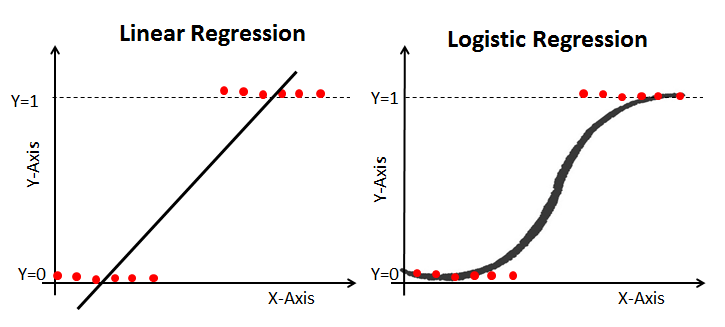

Types of Logistic Regression:

Binary Logistic Regression: The target variable has only two possible outcomes such as Spam or Not Spam, Cancer or No Cancer.

Multinomial Logistic Regression: The target variable has three or more nominal categories such as predicting the type of Wine.

Ordinal Logistic Regression: the target variable has three or more ordinal categories such as restaurant or product rating from 1 to 5.

In [160]:
df_Records.head()

,Rk,Tm,W,L,W-L%,R,RA,Rdiff,SOS,SRS,pythWL,Luck,vEast,vCent,vWest,Inter,Home,Road,ExInn,1Run,vRHP,vLHP,≥.500,<.500
0,1,San Francisco Giants,97,65,0.599,5.7,4.6,1.1,-0.1,1.0,97-65,0,27-17,36-17,26-24,2021-08-07 00:00:00,55-26,42-39,2021-07-05 00:00:00,18-22,78-45,19-20,43-42,54-23
1,2,St. Louis Cardinals,95,67,0.586,5.5,4.8,0.7,-0.1,0.6,91-71,4,25-16,37-25,26-18,2021-07-08 00:00:00,50-31,45-36,2021-05-02 00:00:00,28-16,78-44,17-23,33-37,62-30
2,3,Chicago White Sox,95,67,0.586,6.0,5.2,0.9,0.0,0.9,92-70,3,30-24,29-20,24-17,2021-12-06 00:00:00,46-35,49-32,2021-07-04 00:00:00,28-18,74-57,21-10,49-35,46-32
3,4,Atlanta Braves,95,67,0.586,5.0,4.4,0.6,-0.2,0.4,90-72,5,27-24,25-23,32-13,2021-11-07 00:00:00,51-30,44-37,2021-03-05 00:00:00,18-18,74-53,21-14,42-33,53-34
4,5,New York Mets,94,68,0.580,5.0,4.6,0.4,-0.1,0.3,88-74,6,27-23,34-16,24-20,2021-09-09 00:00:00,55-26,39-42,2021-10-08 00:00:00,29-20,76-55,18-13,42-36,52-32


In [161]:
#split dataset in features and target variable
feature_cols = ['R', 'RA', 'Rdiff']
X = df_Records[feature_cols] # Features
y = df_Records.W # Target variable

In [162]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

So if you are facing the same problem you should check the shape of clf.fit(X,y)parameters:

X : Training vector {array-like, sparse matrix}, shape (n_samples, n_features).

y : Target vector relative to X array-like, shape (n_samples,).

as you can see the y width should be 1, to make sure your target vector is shaped correctly try command

y.shape

In [163]:
X_train.shape

(450, 3)

In [164]:
y_train.shape

(450,)

In [165]:
y_train

16    80
23    72
8     87
20    73
17    83
      ..
7     88
9     86
29    56
12    83
19    77
Name: W, Length: 450, dtype: int64

In [166]:
from sklearn import preprocessing
import numpy as np

scaler = preprocessing.StandardScaler().fit(X_train)

In [167]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [168]:
scaler.mean_

array([ 4.56666667e+00,  4.57155556e+00, -3.55555556e-03])

In [169]:
scaler.scale_

array([0.51059878, 0.53966226, 0.68305573])

In [170]:
X_scaled = scaler.transform(X_train)
X_scaled

array([[ 0.26113132,  0.05270786,  0.1516063 ],
       [-1.10980812,  0.23800894, -1.0196012 ],
       [ 0.26113132, -0.50319538,  0.59080912],
       ...,
       [-1.5015051 ,  0.6086111 , -1.60520495],
       [ 0.6528283 ,  0.23800894,  0.1516063 ],
       [-0.71811113, -0.3178943 , -0.28759651]])

In [171]:
X_scaled.mean(axis=0)

array([4.69747698e-16, 3.15796771e-16, 7.89491929e-18])

In [172]:
X_scaled.std(axis=0)

array([1., 1., 1.])

In [173]:
X_test = X_scaled

In [174]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [175]:
X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.96

In [176]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [177]:
# import the metrics class
'''
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
'''

'\nfrom sklearn import metrics\ncnf_matrix = metrics.confusion_matrix(y_test, y_pred)\ncnf_matrix\n'

In [178]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [179]:
#split dataset in features and target variable
'''
feature_cols = ['RA9opp', 'RA9def', 'RAR']
X1 = df_PitchStats[feature_cols] # Features
y1 = df_Records.W # Target variable
'''

"\nfeature_cols = ['RA9opp', 'RA9def', 'RAR']\nX1 = df_PitchStats[feature_cols] # Features\ny1 = df_Records.W # Target variable\n"

In [180]:
#X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.25,random_state=0)

In [181]:
#X_train1.shape

In [182]:
#y_train1.shape

In [183]:
#scaler = preprocessing.StandardScaler().fit(X_train1)

In [184]:
#X_scaled1 = scaler.transform(X_train1)
#X_scaled1

In [185]:
#X_train1 = X_scaled1

In [186]:
'''
X1, y1 = make_classification(random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train1, y_train1)  # apply scaling on training data

pipe.score(X_test1, y_test1)  # apply scaling on testing data, without leaking training data.
'''

'\nX1, y1 = make_classification(random_state=42)\nX_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42)\npipe = make_pipeline(StandardScaler(), LogisticRegression())\npipe.fit(X_train1, y_train1)  # apply scaling on training data\n\npipe.score(X_test1, y_test1)  # apply scaling on testing data, without leaking training data.\n'

In [187]:
# import the class
#from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
#logreg = LogisticRegression()

# fit the model with data
#logreg.fit(X_train1,y_train1)

#y_pred1=logreg.predict(X_test1)

In [188]:
# import the metrics class
'''
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test1, y_pred1)
cnf_matrix
'''

'\nfrom sklearn import metrics\ncnf_matrix = metrics.confusion_matrix(y_test1, y_pred1)\ncnf_matrix\n'

In [189]:
#split dataset in features and target variable
'''
feature_cols = ['RA9opp', 'RA9def', 'RAR']
X2 = df_PitchStats[feature_cols] # Features
y2 = df_PitchStats.R # Target variable
'''

"\nfeature_cols = ['RA9opp', 'RA9def', 'RAR']\nX2 = df_PitchStats[feature_cols] # Features\ny2 = df_PitchStats.R # Target variable\n"

In [190]:
#X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.25,random_state=0)

In [191]:
#X_train2.shape

In [192]:
#y_train2.shape

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

In [194]:
# split X and y into training and testing sets
'''
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.25,random_state=0)
'''

'\nfrom sklearn.model_selection import train_test_split\nX_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.25,random_state=0)\n'

In [195]:
# import the class
'''
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train2,y_train2)

#
y_pred2=logreg.predict(X_test2)
'''

'\nfrom sklearn.linear_model import LogisticRegression\n\n# instantiate the model (using the default parameters)\nlogreg = LogisticRegression()\n\n# fit the model with data\nlogreg.fit(X_train2,y_train2)\n\n#\ny_pred2=logreg.predict(X_test2)\n'

In [196]:
# import the metrics class
'''
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test2, y_pred2)
cnf_matrix
'''

'\nfrom sklearn import metrics\ncnf_matrix = metrics.confusion_matrix(y_test2, y_pred2)\ncnf_matrix\n'

In [197]:
# all parameters not specified are set to their defaults
#logisticRegr = LogisticRegression()

In [198]:
#logisticRegr.fit(X_train2, y_train2)

The warning means what it mainly says: Suggestions to try to make the solver (the algorithm) converges.

lbfgs stand for: "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm". It is one of the solvers' algorithms provided by Scikit-Learn Library.

The term limited-memory simply means it stores only a few vectors that represent the gradients approximation implicitly.

It has better convergence on relatively small datasets.

But what is algorithm convergence?

In simple words. If the error of solving is ranging within very small range (i.e., it is almost not changing), then that means the algorithm reached the solution (not necessary to be the best solution as it might be stuck at what so-called "local Optima").

On the other hand, if the error is varying noticeably (even if the error is relatively small [like in your case the score was good], but rather the differences between the errors per iteration is greater than some tolerance) then we say the algorithm did not converge.

Now, you need to know that Scikit-Learn API sometimes provides the user the option to specify the maximum number of iterations the algorithm should take while it's searching for the solution in an iterative manner:

LogisticRegression(... solver='lbfgs', max_iter=100 ...)
As you can see, the default solver in LogisticRegression is 'lbfgs' and the maximum number of iterations is 100 by default.

Final words, please, however, note that increasing the maximum number of iterations does not necessarily guarantee convergence, but it certainly helps!

In [199]:
#X_train2

In [200]:
'''
plt.scatter(X_train2, y_train2, marker='.', alpha = .5, color='navy')
plt.gcf().set_size_inches((12,10))
plt.xlabel('X_train2 Data', fontsize = 19)
plt.ylabel('y_train2 Data', fontsize = 19)
plt.title('Looking for Convergence Issues', fontsize = 22)

plt.show()
'''

"\nplt.scatter(X_train2, y_train2, marker='.', alpha = .5, color='navy')\nplt.gcf().set_size_inches((12,10))\nplt.xlabel('X_train2 Data', fontsize = 19)\nplt.ylabel('y_train2 Data', fontsize = 19)\nplt.title('Looking for Convergence Issues', fontsize = 22)\n\nplt.show()\n"

A frequent problem in estimating logistic regression models is a failure of the likelihood maximization algorithm to
converge. In most cases, this failure is a consequence of data patterns known as complete or quasi-complete
separation. For these patterns, the maximum likelihood estimates simply do not exist.

Decision Boundary
To get a better sense of what a logistic regression hypothesis function computes, we need to know of a concept called ‘decision boundary’. The prediction function that we are using will return a probability score between 0 and 1. To map this score to a discrete class (positive/negative, true/false), we select a threshold value, say 0.5, above which we classify values into class 1 and below which the values will fall into class 2.
For instance, say the prediction function returns a value of 0.8, this would get classified as true/positive (as it is above the selected value of threshold). A value of 0.3, on the other hand, would get classified as false/negative. When dealing with multivariate logistic regression, we select the class with the highest predicted probability.

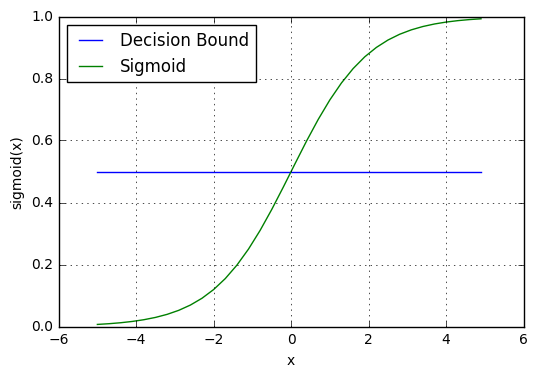

Citation: https://towardsdatascience.com/multivariate-logistic-regression-in-python-7c6255a286ec

In [201]:
# Import 'LogisticRegression' and create a LogisticRegression object
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [202]:
df_MLB_HomeTeams

,Result,HomeTeam,Runs,RA,HomeWin,HomeLastWin,VisitorLastWin
0,0.0,1.0,2.0,3.0,0,0,1
1,0.0,1.0,3.0,5.0,0,0,1
2,1.0,1.0,12.0,6.0,1,0,1
4,1.0,1.0,7.0,3.0,1,1,0
5,1.0,1.0,7.0,5.0,1,1,0
...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,0,1,0
3604,1.0,1.0,9.0,1.0,1,0,1
3605,0.0,1.0,3.0,4.0,0,1,0
3606,1.0,1.0,7.0,2.0,1,0,1


In [203]:
#split dataset in features and target variable

X = df_MLB_HomeTeams.HomeLastWin # Feature
y = df_MLB_HomeTeams.HomeWin # Target variable

In [204]:
X.shape

(48066,)

In [205]:
X.values.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [206]:
y.shape

(48066,)

In [207]:
y.values.reshape(-1,1)

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [208]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [209]:
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)

Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [210]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

In [211]:
# fit the model with data
logreg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [212]:
y_pred=logreg.predict(X_test)

In [213]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [214]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[   0, 5520],
       [   0, 6497]])

In [215]:
from matplotlib import rc
rc('text', usetex = False)

Text(0.5, 257.44, 'Predicted label')

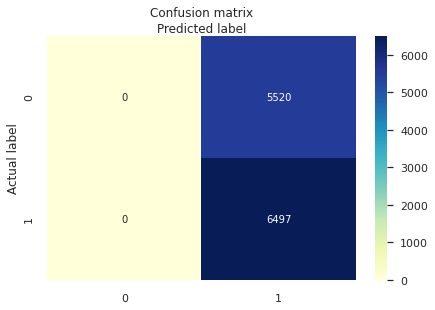

In [216]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [217]:
from sklearn.metrics import f1_score

In [218]:
y_true = y_test

In [219]:
f1_score(y_true, y_pred, average='macro')

0.35092362536458893

In [220]:
f1_score(y_true, y_pred, average='micro')

0.5406507447782308

In [221]:
f1_score(y_true, y_pred, average='weighted')

0.37945423882728374

In [222]:
f1_score(y_true, y_pred, average=None)

array([0.        , 0.70184725])

In [223]:
f1_score(y_true, y_pred, zero_division=1)

0.7018472507291779

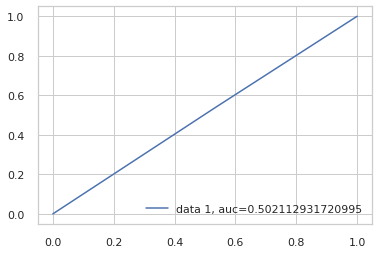

In [224]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [225]:
def sigmoid(z):
  return 1.0 / (1 + np.exp(-z))

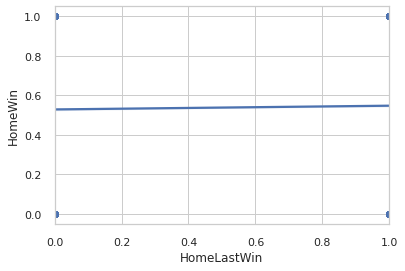

In [226]:
sns.regplot(x='HomeLastWin', y='HomeWin', data=df_MLB_HomeTeams, logistic=True)

In [227]:
import sklearn.linear_model
plt.rc('text', usetex=True)

In [228]:
X = X_train # Feature
y = y_train # Target variable

In [229]:
# Fit the data to a logistic regression model.
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [230]:
# Retrieve the model parameters.
'''
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -1, 2
ymin, ymax = -1, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X[Y==0].T, s=8, alpha=0.5)
plt.scatter(*X[Y==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()
'''

"\nb = clf.intercept_[0]\nw1, w2 = clf.coef_.T\n# Calculate the intercept and gradient of the decision boundary.\nc = -b/w2\nm = -w1/w2\n\n# Plot the data and the classification with the decision boundary.\nxmin, xmax = -1, 2\nymin, ymax = -1, 2.5\nxd = np.array([xmin, xmax])\nyd = m*xd + c\nplt.plot(xd, yd, 'k', lw=1, ls='--')\nplt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)\nplt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)\n\nplt.scatter(*X[Y==0].T, s=8, alpha=0.5)\nplt.scatter(*X[Y==1].T, s=8, alpha=0.5)\nplt.xlim(xmin, xmax)\nplt.ylim(ymin, ymax)\nplt.ylabel(r'$x_2$')\nplt.xlabel(r'$x_1$')\n\nplt.show()\n"

Let me put in the confusion matrix and its parts here.

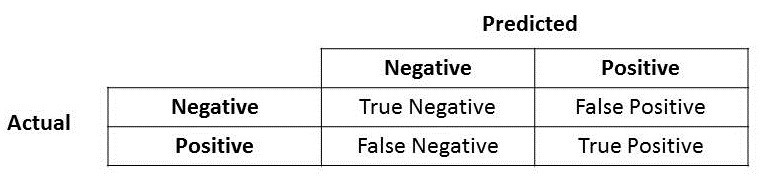

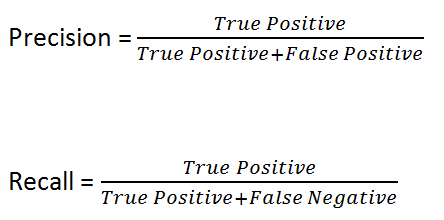

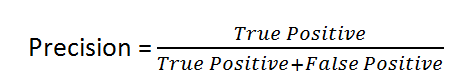

Immediately, you can see that Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.
Precision is a good measure to determine, when the costs of False Positive is high.

So Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.

Citation: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9



In [231]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.5406507447782308
Precision: 0.5406507447782308
Recall: 1.0


**Problem Setup**
Classification involves building a best fit equation to predict the probability an observation is of a certain class/label. Let's break down what some of those terms mean.

In order to use a classification algorithm, you must be provided with observations, features and labeled data.

In the table above, 

**Obserevation:**
Each row is considered an observation. With each observation as a record of a single baseball game and all of the statistics included in the completion of this baseball game.

**Features:**
The columns are considered features. They are measurable characteristics for each observation.

**Labeled Data:** 
The result of the game is a group of samples that have been tagged with a label of either "win" or "loss". Labeling typically takes a set of unlabeled data and augments each piece of it with informative tags. So, in our example someone who knows absolutely nothing about baseball can still understand what the labels of "win" and "loss" mean.

**Binary Classification**
In our example above, there were just two possible class labels - either "win" or "loss". Therefore, this is considered a binary classification example. The term binary means related to two things.



In [232]:
df_MLB_HomeTeamsRanked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin,HomeLastWin,VisitorLastWin
0,0.0,1.0,2.0,3.0,18,LAA,0,0,1
1,0.0,1.0,3.0,5.0,18,LAA,0,0,1
2,1.0,1.0,12.0,6.0,18,LAA,1,0,1
4,1.0,1.0,7.0,3.0,18,LAA,1,1,0
5,1.0,1.0,7.0,5.0,18,LAA,1,1,0
...,...,...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,12,NYY,0,1,0
3604,1.0,1.0,9.0,1.0,12,NYY,1,0,1
3605,0.0,1.0,3.0,4.0,12,NYY,0,1,0
3606,1.0,1.0,7.0,2.0,12,NYY,1,0,1


In [233]:
df_RankingReg = pd.DataFrame(df_MLB_HomeTeamsRanked, columns = ['Rank', 'HomeWin'])

In [234]:
df_RankingReg

,Rank,HomeWin
0,18,0
1,18,0
2,18,1
4,18,1
5,18,1
...,...,...
3603,12,0
3604,12,1
3605,12,0
3606,12,1


In [235]:
# Add a new column named 'Price'
df_RankingReg['Game_Result'] = ['Win' if x ==1 else 'Loss' for x in df_RankingReg['HomeWin']]
  
# Print the DataFrame
print(df_RankingReg)

      Rank  HomeWin Game_Result
0       18        0        Loss
1       18        0        Loss
2       18        1         Win
4       18        1         Win
5       18        1         Win
...    ...      ...         ...
3603    12        0        Loss
3604    12        1         Win
3605    12        0        Loss
3606    12        1         Win
3607    12        1         Win

[48066 rows x 3 columns]


In [236]:
#df_PitchingAVG.to_csv(r'/content/df_MLB_PitchingStatsAVG.csv', index = True)
df_RankingReg.head()

,Rank,HomeWin,Game_Result
0,18,0,Loss
1,18,0,Loss
2,18,1,Win
4,18,1,Win
5,18,1,Win


In [237]:
df_RankingGrouped = df_RankingReg.groupby('Rank')['Game_Result'].value_counts().to_frame()

In [238]:
df_RankingGrouped.to_csv(r'/content/df_MLB_GameResults.csv', index = True)

In [239]:
df_RankingGrouped_Updated = pd.read_csv('/content/MLB_Ranking_WinPercent.csv')
#df_MLB_WinRanked = df_RankingGrouped_Updated.Rank_WinPercent
#df_MLB_WinRanked
df_RankingGrouped_Updated

,Team,Rank_WinPercent
0,Yankees,1
1,Cardinals,2
2,Dodgers,3
3,RedSox,4
4,Athletics,5
5,Braves,6
6,Angels,7
7,Giants,8
8,Indians,9
9,Rockies,10


In [240]:
df_RankingWinPer = pd.read_csv('/content/df_MLB_GameResults_updated.csv')
df_RankingWinPer

,Rank_WinPer,Rank,Win,Loss,Games,Win_Percent
0,1,12,992,594,1586,0.625473
1,2,2,963,644,1607,0.599253
2,3,3,952,669,1621,0.587292
3,4,11,925,657,1582,0.584703
4,5,27,933,683,1616,0.577351
5,6,28,910,689,1599,0.569106
6,7,18,911,708,1619,0.562693
7,8,13,897,718,1615,0.555418
8,9,10,874,715,1589,0.550031
9,10,23,870,726,1596,0.545113


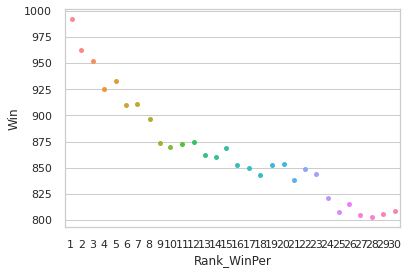

In [241]:
from matplotlib import rc
rc('text', usetex = False)
       
sb.set(style = 'whitegrid')  
Wins = df_RankingWinPer  
       
sb.stripplot(x=df_RankingWinPer.Rank_WinPer, y=df_RankingWinPer.Win, data=Wins)
  
plt.show()

In [242]:
#split dataset in features and target variable

X = df_RankingWinPer.Rank_WinPer # Feature
y = df_RankingWinPer.Win # Target variable

In [243]:
X.shape

(30,)

In [244]:
X = X.values.reshape(-1,1)

In [245]:
y.shape

(30,)

In [246]:
y = y.values.reshape(-1,1)

In [247]:
X

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30]])

In [248]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, y)  # perform linear regression
y_pred = linear_regressor.predict(X)  # make predictions

In statistics, linear regression is a linear approach to modelling the relationship between a dependent variable and one or more independent variables. 



*   Linear Regression using Gradient Descent
*   Linear Regression Using Least Squares

Citation: https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

In [249]:
from matplotlib import rc
rc('text', usetex = False)

In [250]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

In [251]:
df_RankingWinPitch = pd.read_csv('/content/MLB_Ranking_WinPer_Pitch.csv')
#df_MLB_WinRanked = df_RankingGrouped_Updated.Rank_WinPercent
#df_MLB_WinRanked
df_RankingWinPitch

,Team,Rank_WinPercent,Pitching_Ranking,Wins
0,Yankees,1,2,992
1,Cardinals,2,17,963
2,Dodgers,3,3,952
3,RedSox,4,4,925
4,Athletics,5,1,933
5,Braves,6,7,910
6,Angels,7,8,911
7,Giants,8,13,897
8,Indians,9,6,874
9,Rockies,10,26,870


In [252]:
# Linear Regression
X = df_RankingWinPitch['Pitching_Ranking'] 
winNum = df_RankingWinPitch['Wins']

In [253]:
X = X.values.reshape(-1,1)
winNum = winNum.values.reshape(-1,1)

In [254]:
pitch_rank = df_RankingWinPitch['Pitching_Ranking'] 
wins_pitch = df_RankingWinPitch['Wins']

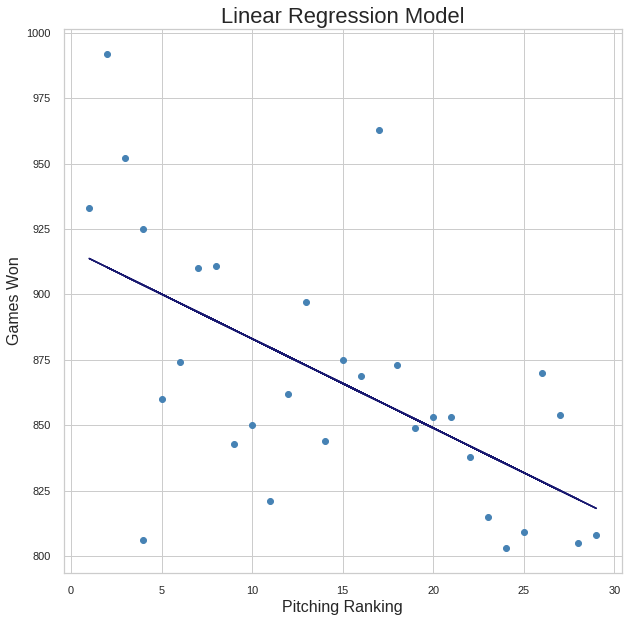

In [255]:
model = LinearRegression(fit_intercept=True)
model.fit(X, winNum)
predictions = model.predict(X)
plt.scatter(X, winNum, color='steelblue')
plt.plot(X, predictions, color='midnightblue')
plt.gcf().set_size_inches((10,10))
#plt.text(605, 82, 'R-Squared: ' + str(round((np.corrcoef(winNum, runNum)[1][0])**2, 2)), fontsize=14, color='black')
plt.xlabel('Pitching Ranking', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Linear Regression Model', fontsize = 22)
plt.style.use('seaborn')

In [256]:
# Linear Regression
X2 = df_RankingWinPitch['Rank_WinPercent'] 
winNum2 = df_RankingWinPitch['Wins']

In [257]:
X2 = X2.values.reshape(-1,1)
winNum2 = winNum2.values.reshape(-1,1)

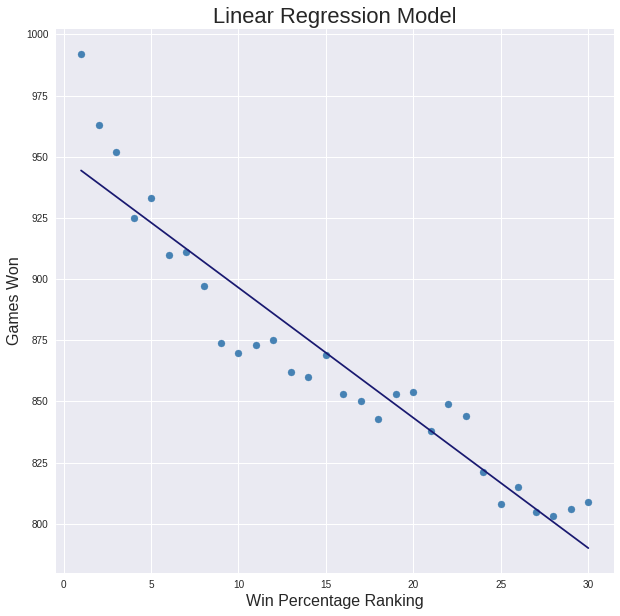

In [258]:
model = LinearRegression(fit_intercept=True)
model.fit(X2, winNum2)
predictions2 = model.predict(X2)
plt.scatter(X2, winNum2, color='steelblue')
plt.plot(X2, predictions2, color='midnightblue')
plt.gcf().set_size_inches((10,10))
#plt.text(605, 82, 'R-Squared: ' + str(round((np.corrcoef(winNum, runNum)[1][0])**2, 2)), fontsize=14, color='black')
plt.xlabel('Win Percentage Ranking', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Linear Regression Model', fontsize = 22)
plt.style.use('seaborn')

In [259]:
## fit a OLS model
X2 = sm.add_constant(X2)
est = sm.OLS(winNum2, X2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     236.5
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           3.50e-15
Time:                        22:29:06   Log-Likelihood:                -125.46
No. Observations:                  30   AIC:                             254.9
Df Residuals:                      28   BIC:                             257.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        949.6989      6.142    154.616      0.000     937.117     962.281
x1            -5.3204      0.346    -15.377      0.000      -6.029      -4.612
==============================================================================
Omnibus:                        5.145   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                3.443
Skew:                           0.703   Prob(JB):                        0.179
Kurtosis:                       3.881   Cond. No.                         36.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [260]:
X = df_RankingWinPitch[['Rank_WinPercent', 'Pitching_Ranking']] 
y = df_RankingWinPitch['Wins']
## fit a OLS model
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wins   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     116.4
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           5.33e-14
Time:                        22:29:06   Log-Likelihood:                -125.18
No. Observations:                  30   AIC:                             256.4
Df Residuals:                      27   BIC:                             260.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              951.4852      6.691    142.213      0.000     937.757     965.213
Rank_WinPercent     -5.1397      0.432    -11.890      0.000      -6.027      -4.253
Pitching_Ranking    -0.3135      0.442     -0.709      0.485      -1.221       0.594
==============================================================================
Omnibus:                        4.948   Durbin-Watson:                   0.535
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                3.282
Skew:                           0.712   Prob(JB):                        0.194
Kurtosis:                       3.773   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
from matplotlib import rc
rc('text', usetex = False)

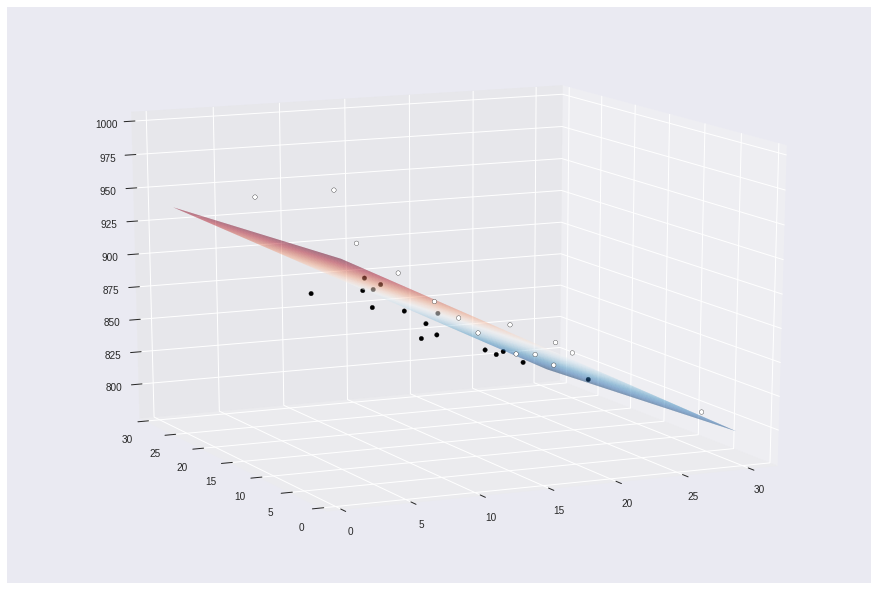

In [262]:
## Create the 3d plot -- skip reading this
# TV/Radio grid for 3d plot
xx1, xx2 = np.meshgrid(np.linspace(X.Rank_WinPercent.min(), X.Rank_WinPercent.max(), 100),
np.linspace(X.Pitching_Ranking.min(), X.Pitching_Ranking.max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(X[resid >= 0].Rank_WinPercent, X[resid >= 0].Pitching_Ranking, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0].Rank_WinPercent, X[resid < 0].Pitching_Ranking, y[resid < 0], color='black', alpha=1.0)
#ax.scatter(X[resid >= 0].Rank_WinPercent, X[resid >= 0].Rank_Batting, y[resid >= 0], color='blue', alpha=1.0, facecolor='blue')

# set axis labels
#ax.set_xlabel('Winning Percent Ranking')
#ax.set_ylabel('Pitching Ranking')
#ax.set_zlabel('Wins')

In [263]:
df_RankingWinPitchBatting = pd.read_csv('/content/MLB_Ranking_WinPer_Pitch_Batting.csv')
#df_MLB_WinRanked = df_RankingGrouped_Updated.Rank_WinPercent
#df_MLB_WinRanked
df_RankingWinPitchBatting

,Team,Rank_WinPercent,Pitching_Ranking,Rank_Batting,Wins
0,Yankees,1,2,2,992
1,Cardinals,2,17,5,963
2,Dodgers,3,3,29,952
3,RedSox,4,4,1,925
4,Athletics,5,1,18,933
5,Braves,6,7,12,910
6,Angels,7,8,8,911
7,Giants,8,13,25,897
8,Indians,9,6,6,874
9,Rockies,10,26,3,870


In [264]:
# Linear Regression
X3 = df_RankingWinPitchBatting['Rank_Batting'] 
winNum3 = df_RankingWinPitchBatting['Wins']

In [265]:
X3 = X3.values.reshape(-1,1)
winNum3 = winNum3.values.reshape(-1,1)

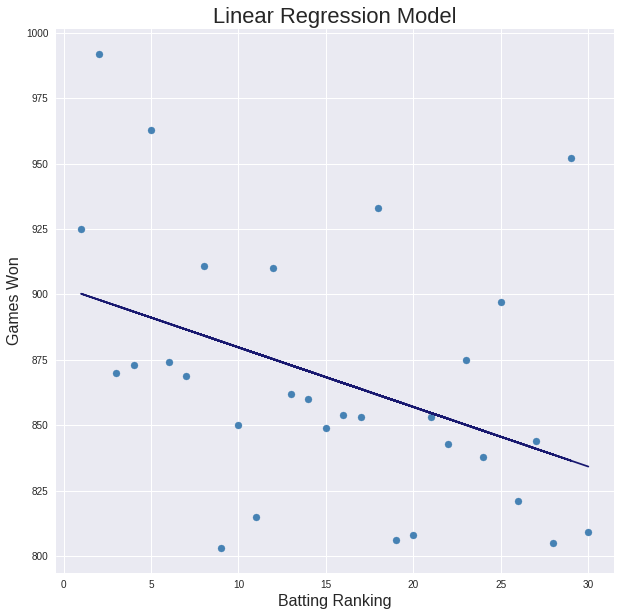

In [266]:
model = LinearRegression(fit_intercept=True)
model.fit(X3, winNum)
predictions3 = model.predict(X3)
plt.scatter(X3, winNum3, color='steelblue')
plt.plot(X3, predictions3, color='midnightblue')
plt.gcf().set_size_inches((10,10))
#plt.text(605, 82, 'R-Squared: ' + str(round((np.corrcoef(winNum, runNum)[1][0])**2, 2)), fontsize=14, color='black')
plt.xlabel('Batting Ranking', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Linear Regression Model', fontsize = 22)
plt.style.use('seaborn')

In [267]:
#df_RankingWinPitchBatting.to_csv(r'/content/RankingWinPitchBatting.csv', index = True)

In [268]:
df_RankingWinPitchBatting = pd.read_csv('/content/RankingWinPitchBatting.csv')
#df_MLB_WinRanked = df_RankingGrouped_Updated.Rank_WinPercent
#df_MLB_WinRanked
df_RankingWinPitchBatting

,Unnamed: 0,Team,Rank_WinPercent,Pitching_Ranking,Rank_Batting,Wins,Win_Percent
0,0,Yankees,1,2,2,992,0.625
1,1,Cardinals,2,17,5,963,0.599
2,2,Dodgers,3,3,29,952,0.587
3,3,RedSox,4,4,1,925,0.585
4,4,Athletics,5,1,18,933,0.577
5,5,Braves,6,7,12,910,0.569
6,6,Angels,7,8,8,911,0.563
7,7,Giants,8,13,25,897,0.555
8,8,Indians,9,6,6,874,0.550
9,9,Rockies,10,26,3,870,0.545


Understanding Multiple Regression
In Ordinary Least Squares Regression with a single variable we described the relationship between the predictor and the response with a straight line. In the case of multiple regression we extend this idea by fitting a (p)-dimensional hyperplane to our (p) predictors.

We can show this for two predictor variables in a three dimensional plot. In the following example we will use the advertising dataset which consists of the sales of products and their advertising budget in three different media

The multiple regression model describes the response as a weighted sum of the predictors:

(Sales = beta_0 + beta_1 times TV + beta_2 times Radio)This model can be visualized as a 2-d plane in 3-d space:

The plot above shows data points above the hyperplane in white and points below the hyperplane in black. The color of the plane is determined by the corresponding predicted Sales values (blue = low, red = high). The Python code to generate the 3-d plot can be found in the appendix.

Just as with the single variable case, calling est.summary will give us detailed information about the model fit. You can find a description of each of the fields in the tables below in the previous blog post here.

Citation: https://www.datarobot.com/blog/multiple-regression-using-statsmodels/


In [269]:
X = df_RankingWinPitchBatting[['Rank_WinPercent', 'Pitching_Ranking', 'Rank_Batting']] 
y = df_RankingWinPitchBatting['Wins']
## fit a OLS model
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wins   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     75.25
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           6.05e-13
Time:                        22:29:08   Log-Likelihood:                -125.08
No. Observations:                  30   AIC:                             258.2
Df Residuals:                      26   BIC:                             263.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              947.4364      7.702    123.005      0.000     931.604     963.269
Rank_WinPercent     -5.4210      0.595     -9.114      0.000      -6.644      -4.198
Pitching_Ranking    -0.0646      0.535     -0.121      0.905      -1.165       1.036
Rank_Batting         0.3112      0.414      0.751      0.459      -0.540       1.162
==============================================================================
Omnibus:                        7.933   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.285
Skew:                           0.903   Prob(JB):                       0.0432
Kurtosis:                       4.330   Cond. No.                         74.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
from matplotlib import rc
rc('text', usetex = False)

Text(0.5, 0, 'Wins')

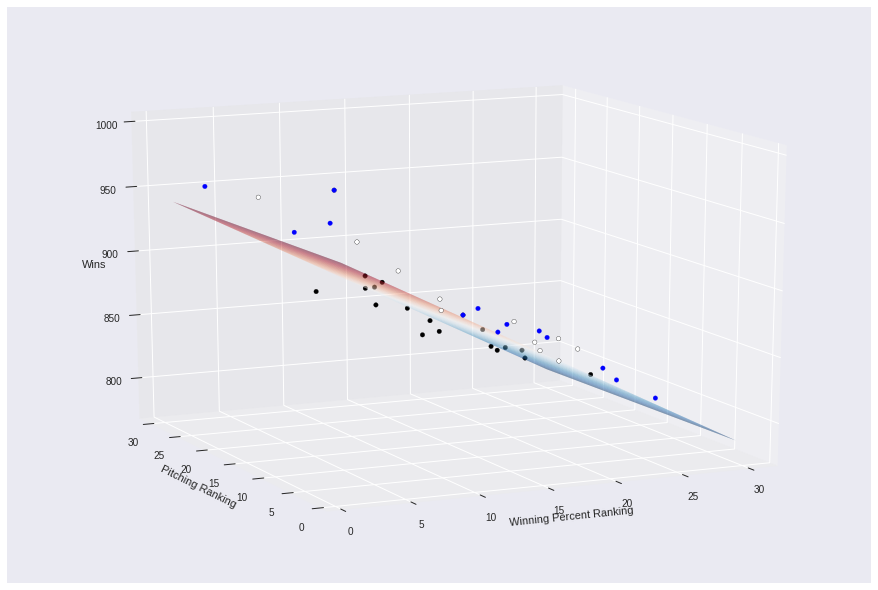

In [271]:
## Create the 3d plot -- skip reading this
# TV/Radio grid for 3d plot
xx1, xx2 = np.meshgrid(np.linspace(X.Rank_WinPercent.min(), X.Rank_WinPercent.max(), 100),
np.linspace(X.Pitching_Ranking.min(), X.Pitching_Ranking.max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(X[resid >= 0].Rank_WinPercent, X[resid >= 0].Pitching_Ranking, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0].Rank_WinPercent, X[resid < 0].Pitching_Ranking, y[resid < 0], color='black', alpha=1.0)
ax.scatter(X[resid >= 0].Rank_WinPercent, X[resid >= 0].Rank_Batting, y[resid >= 0], color='blue', alpha=1.0, facecolor='blue')

# set axis labels
ax.set_xlabel('Winning Percent Ranking')
ax.set_ylabel('Pitching Ranking')
ax.set_zlabel('Wins')


In [272]:
'''
X_Rev = df_RankingWinPitchBatting_Rev[['Rank_WinPercent', 'Pitching_Ranking', 'Rank_Batting']] 
y_Rev = df_RankingWinPitchBatting_Rev['Wins']
## fit a OLS model
X_Rev = sm.add_constant(X_Rev)
est = sm.OLS(y_Rev, X_Rev).fit()
est.summary()
'''

"\nX_Rev = df_RankingWinPitchBatting_Rev[['Rank_WinPercent', 'Pitching_Ranking', 'Rank_Batting']] \ny_Rev = df_RankingWinPitchBatting_Rev['Wins']\n## fit a OLS model\nX_Rev = sm.add_constant(X_Rev)\nest = sm.OLS(y_Rev, X_Rev).fit()\nest.summary()\n"

Adding 4th Dimension:
We know we cannot visualize higher dimensions directly, but here’s the trick: We can use fake depth to visualize higher dimensions by using variations such as color, size and shapes.

Here, along with earlier 3 features, we will use city mileage feature- city-mpg as fourth dimension, which is varied using marker colors by parameter markercolor of Scatter3D. Here lighter blue color represents lower mileage.
Observations: It’s pretty evident from the 4D plot that higher the price, horsepower and curb weight, lower the mileage.

Citation: https://medium.com/@prasadostwal/multi-dimension-plots-in-python-from-2d-to-6d-9a2bf7b8cc74


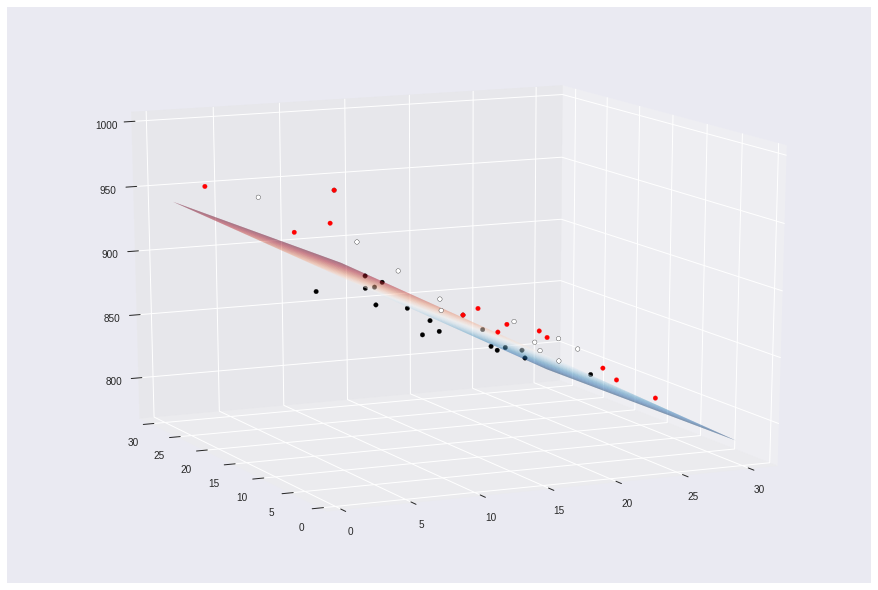

In [273]:
## Create the 3d plot -- skip reading this
# TV/Radio grid for 3d plot
xx1, xx2 = np.meshgrid(np.linspace(X.Rank_WinPercent.min(), X.Rank_WinPercent.max(), 100),
np.linspace(X.Pitching_Ranking.min(), X.Pitching_Ranking.max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(X[resid >= 0].Rank_WinPercent, X[resid >= 0].Pitching_Ranking, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0].Rank_WinPercent, X[resid < 0].Pitching_Ranking, y[resid < 0], color='black', alpha=1.0)
ax.scatter(X[resid >= 0].Rank_WinPercent, X[resid >= 0].Rank_Batting, y[resid >= 0], color='red', alpha=1.0, facecolor='red')

# set axis labels
#ax.set_xlabel('Winning Percent Ranking', fontsize=20)
#ax.set_ylabel('Pitching Ranking', fontsize=20)
#ax.set_zlabel('Wins', fontsize=20)

In [274]:
#Team_Ranking = Rank_WinPercent
#Game_Outcome = df_RankingReg.HomeWin

In [275]:
'''
yearly_incomes_us_dollars = df_RankingGrouped_Updated.Rank_updated
credit_card_decisions = ["denied"]*4 + ["approved"] + ["denied"]*2 + ["approved"]*5


Game_data = df_MLB_HomeTeams.Runs
'''

'\nyearly_incomes_us_dollars = df_RankingGrouped_Updated.Rank_updated\ncredit_card_decisions = ["denied"]*4 + ["approved"] + ["denied"]*2 + ["approved"]*5\n\n\nGame_data = df_MLB_HomeTeams.Runs\n'

In [276]:
'''
Game_data = {'HomeTeam_Runs': Runs_Scored,
        'Game_Result': Game_Outcome
        }
df_GameData = pd.DataFrame(Game_data)
'''

"\nGame_data = {'HomeTeam_Runs': Runs_Scored,\n        'Game_Result': Game_Outcome\n        }\ndf_GameData = pd.DataFrame(Game_data)\n"

In [277]:
'''
plt.figure(figsize=(9, 7))
sns.stripplot(data=df_GameData, x="HomeTeam_Runs", y="Game_Result", jitter=False, size=13)
plt.xlabel("Home Team Runs scored", labelpad=13)
plt.ylabel("Game Result", labelpad=13)
plt.title("MLB Baseball Games (2000-2019)", y=1.015, fontsize=20)
ax = plt.gca()
#ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
'''

'\nplt.figure(figsize=(9, 7))\nsns.stripplot(data=df_GameData, x="HomeTeam_Runs", y="Game_Result", jitter=False, size=13)\nplt.xlabel("Home Team Runs scored", labelpad=13)\nplt.ylabel("Game Result", labelpad=13)\nplt.title("MLB Baseball Games (2000-2019)", y=1.015, fontsize=20)\nax = plt.gca()\n#ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));\n'

In [278]:
#df = pd.read_csv('/content/Standings_Total.csv', index_col='Team')

NEEDS UPDATING!!!!!!!!!!!!!

Most Popular Classification Algorithms
These five below I consider classical machine learning algorithms - as many were first profiled tens of years ago.

Logistic Regression
SVM
Naive Bayes
Decision Trees
Random Forest
In this notebook, we're just going to learn Logistic Regression. Why? Well Logistic Regression is simple to implement and fits to data quickly. Also, this model is very interpretable - both in the math with how it works and interpretability of features. Not all other algorithms listed above also fit this criteria.

However, note Logistic Regression is often regarded as one of the simpler classification algorithms. It is just OK at capturing the variance with many features. So, you likely won't get as strong of a fit of a model with it compared to more complex machine learning models like XGBoost or neural networks.

In [279]:
'''
plt.scatter(df_Records['W'], df_PitchStats['R'], color='green')
plt.title('Wins Vs Runs', fontsize=14)
plt.xlabel('Runs', fontsize=14)
plt.ylabel('Wins', fontsize=14)
plt.grid(True)
plt.show()
'''

"\nplt.scatter(df_Records['W'], df_PitchStats['R'], color='green')\nplt.title('Wins Vs Runs', fontsize=14)\nplt.xlabel('Runs', fontsize=14)\nplt.ylabel('Wins', fontsize=14)\nplt.grid(True)\nplt.show()\n"

What is a heatmap?
A heatmap is a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors. The seaborn python package allows the creation of annotated heatmaps which can be tweaked using Matplotlib tools as per the creator’s requirement.



In [280]:
df_MLB_HomeTeamsRanked

,Result,HomeTeam,Runs,RA,Rank,Team,HomeWin,HomeLastWin,VisitorLastWin
0,0.0,1.0,2.0,3.0,18,LAA,0,0,1
1,0.0,1.0,3.0,5.0,18,LAA,0,0,1
2,1.0,1.0,12.0,6.0,18,LAA,1,0,1
4,1.0,1.0,7.0,3.0,18,LAA,1,1,0
5,1.0,1.0,7.0,5.0,18,LAA,1,1,0
...,...,...,...,...,...,...,...,...,...
3603,0.0,1.0,2.0,3.0,12,NYY,0,1,0
3604,1.0,1.0,9.0,1.0,12,NYY,1,0,1
3605,0.0,1.0,3.0,4.0,12,NYY,0,1,0
3606,1.0,1.0,7.0,2.0,12,NYY,1,0,1


In [281]:
#split dataset in features and target variable

XX3 = df_MLB_HomeTeamsRanked.HomeLastWin # Feature
yy3 = df_MLB_HomeTeams.HomeWin # Target variable

In [282]:
# defining the dependent and independent variables
XX3train = df_MLB_HomeTeamsRanked[['HomeLastWin', 'Runs']]
yy3train = df_MLB_HomeTeamsRanked[['HomeWin']]

In [283]:
# building the model and fitting the data
log_reg = sm.Logit(yy3train, XX3train).fit()

Optimization terminated successfully.
         Current function value: 0.601070
         Iterations 5


In [284]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                HomeWin   No. Observations:                48066
Model:                          Logit   Df Residuals:                    48064
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Aug 2021   Pseudo R-squ.:                  0.1291
Time:                        22:29:10   Log-Likelihood:                -28891.
converged:                       True   LL-Null:                       -33172.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
HomeLastWin    -0.8318      0.018    -46.552      0.000      -0.867      -0.797
Runs            0.2270      0.003     80.471      0.000       0.221       0.233


In [285]:
# defining the dependent and independent variables
XX3test = df_MLB_HomeTeamsRanked[['HomeLastWin', 'Runs']]
yy3test = df_MLB_HomeTeamsRanked[['HomeWin']]

In [286]:
yy3test

,HomeWin
0,0
1,0
2,1
4,1
5,1
...,...
3603,0
3604,1
3605,0
3606,1


In [287]:
# performing predictions on the test datdaset
yhat = log_reg.predict(XX3test)
prediction = list(map(round, yhat))
  
# comparing original and predicted values of y
print('Acutal values', list(yy3test.values))
print('Predictions :', prediction)

Acutal values [array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), a

In [288]:
# confusion matrix
cm = confusion_matrix(yy3test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(yy3test, prediction))
print('Test precision = ', precision_score(yy3test, prediction))
print('Test recall = ', recall_score(yy3test, prediction))

Confusion Matrix : 
 [[ 9049 13122]
 [ 2643 23252]]
Test accuracy =  0.6720134814629883
Test precision =  0.6392478143729037
Test recall =  0.8979339640857308


In [289]:
f1_score(yy3test, prediction, average='weighted')

0.6488630761765257

In [290]:
f1_score(yy3test, prediction, average='macro')

0.6406359448389185

In [291]:
f1_score(yy3test, prediction, average='micro')

0.6720134814629883

Text(0.5, 352.48, 'Predicted label')

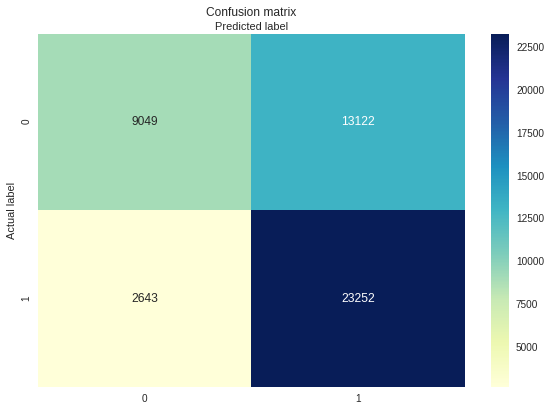

In [292]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')